In [159]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 전처리

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, roc_curve, auc, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import xgboost as xgb

fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

path = "/content/drive/MyDrive/멋쟁이사자처럼 데이터분석/파이널프로젝트/우유/archive (3)/dairy_dataset.csv"
df = pd.read_csv(path)

df.columns = df.columns.str.replace('(liters/kg)', '', regex=False)
df.columns = df.columns.str.replace('(days)', '', regex=False)
df.columns = df.columns.str.replace('(acres)', '', regex=False)
df.columns = df.columns.str.replace('(sold)', 'Sold', regex=False)
df.columns = df.columns.str.replace('(INR)', '', regex=False)
df.columns = df.columns.str.replace('.', '', regex=False)
df.columns = df.columns.str.rstrip()
df = df.rename(columns=lambda x: x.replace(' ', '_'))

storage_map = {
    'Frozen': 'FR',
    'Refrigerated': 'RF',
    'Ambient': 'AM',
    'Polythene Packet': 'PP',
    'Tetra Pack': 'TP'
}

df['Product_Profile'] = df['Storage_Condition'].map(storage_map) + '_' + df['Product_Name']

# 시계열 전처리
df["Date"] = pd.to_datetime(df["Date"])
df["Production_Date"] = pd.to_datetime(df["Production_Date"])
df["Expiration_Date"] = pd.to_datetime(df["Expiration_Date"])
df["Prod_Year"] = df["Production_Date"].dt.year
df["Prod_Month"] = df["Production_Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df['Year_Month_str'] = df['Date'].dt.strftime('%Y-%m')

# ==================================================================
# 1. 연도별 소비자 물가 지수(CPI) 설정
# 2019년을 100으로 기준을 잡고, 연간 인플레이션율을 반영하여 계산
# (Source: World Bank, Macrotrends)
# 2019: 3.73%, 2020: 6.62%, 2021: 5.13%, 2022: 6.70%
cpi_data = {
    2019: 100.0,
    2020: 106.62, # 100 * (1 + 0.0662)
    2021: 112.10, # 106.62 * (1 + 0.0513)
    2022: 119.61  # 112.10 * (1 + 0.0670)
}

# 2. 기준 연도(2019년)의 CPI
base_cpi = cpi_data[2019]

# 3. 'Real_Price_per_Unit' 컬럼 생성
# 각 행의 'Year'에 해당하는 CPI를 가져옵니다.
df['cpi'] = df['Year'].map(cpi_data)

# 실질 가격 계산: 실질가격 = 명목가격 / (해당년도 CPI / 기준년도 CPI)
df['Real_Price_per_Unit_Sold'] = df['Price_per_Unit_Sold'] / (df['cpi'] / base_cpi)

# 4. 결과 확인
# 임시로 사용한 'cpi' 컬럼은 삭제
df.drop('cpi', axis=1, inplace=True)

# Price_per_Unit_Sold 최소최대 정규화
group_cols = ['Product_Name', 'Sales_Channel']
grouped = df.groupby(group_cols)['Real_Price_per_Unit_Sold']
min_prices = grouped.transform('min')
max_prices = grouped.transform('max')
df['Price_Score'] = (df['Real_Price_per_Unit_Sold'] - min_prices) / (max_prices - min_prices)
df['Price_Score'].fillna(0.5, inplace=True)

df['Discount_Rate'] = (df['Price_per_Unit'] - df['Price_per_Unit_Sold']) / df['Price_per_Unit']
# ==================================================================

# 판매기간, 일평균 판매량, 유통기한까지 남은 기간, 예상 폐기량, Stockout될 기간, Risk_Flag
df['Sales_Period_Days'] = (df['Date'] - df['Production_Date']).dt.days
df["Avg_Daily_Sales"] = df["Quantity_Sold"] / (df["Date"] - df["Production_Date"]).dt.days
df['Remaining_Shelf_Life'] = (df['Expiration_Date'] - df['Date']).dt.days

# 제품프로필별 하루 평균 판매량에 대한 ZScore
mean_sales = df.groupby('Product_Profile')['Avg_Daily_Sales'].transform('mean')
std_sales = df.groupby('Product_Profile')['Avg_Daily_Sales'].transform('std')
df['Sales_Velocity_ZScore'] = (df['Avg_Daily_Sales'] - mean_sales) / std_sales
df['Sales_Velocity_ZScore'].fillna(0, inplace=True)

df['Expected_Waste_Qty'] = np.where(
    df['Remaining_Shelf_Life'] <= 0,
    df['Quantity_in_Stock'],
    (df['Quantity_in_Stock'] - (df['Avg_Daily_Sales'] * df['Remaining_Shelf_Life'])).clip(lower=0)
)

df['Expected_Waste_Qty'] = df['Expected_Waste_Qty'].fillna(df['Quantity_in_Stock'])
df['Waste_Rate'] = df['Expected_Waste_Qty'] / df['Quantity']
df['Days_to_Stockout'] = df['Quantity_in_Stock'] / df['Avg_Daily_Sales']
df['Risk_Flag'] = df['Days_to_Stockout'] > df['Remaining_Shelf_Life']
df['Waste_Or_Not'] = np.where(df['Waste_Rate'] > 0, '폐기 발생', '폐기 없음')

# ==================================================================
df['Prod_per_Cow'] = (df['Quantity'] / df['Number_of_Cows']).fillna(0)
df['Revenue_per_Cow'] = df["Approx_Total_Revenue"] / df["Number_of_Cows"]
df['Prod_per_Acre'] = df['Quantity'] / df['Total_Land_Area']

# 'Product_Name'별로 Prod_per_Cow의 중앙값을 계산하여 각 행에 매핑
df['Product_Median_Prod'] = df.groupby('Product_Profile')['Prod_per_Cow'].transform('median')
df['Efficiency_Group_Product'] = df.apply(lambda row: '고효율 농장' if row['Prod_per_Cow'] > row['Product_Median_Prod'] else '저효율 농장', axis=1)
df.drop('Product_Median_Prod', axis=1, inplace=True)

df['Quantity_Median'] = df.groupby('Product_Profile')['Quantity'].transform('median')
df['Quantity_Group'] = df.apply(lambda row: '대량생산 농장' if row['Quantity'] > row['Quantity_Median'] else '소량생산 농장', axis=1)

/tmp/ipython-input-331589040.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price_Score'].fillna(0.5, inplace=True)
/tmp/ipython-input-331589040.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

# 문제정의

--- 연도별 총 매출 (2019-2022) ---
   Prod_Year  Approx_Total_Revenue
0       2019           14907915.13
1       2020           15172454.52
2       2021           14661509.69
3       2022           12524604.56
-----------------------------------


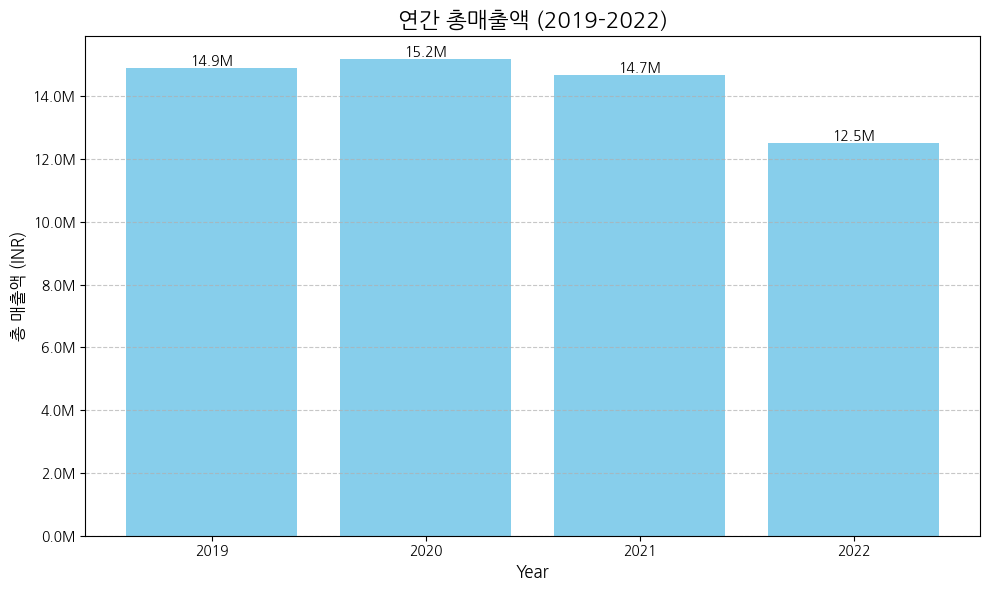

In [161]:
filtered_df = df[(df['Prod_Year'] >= 2019) & (df['Prod_Year'] <= 2022)]
yearly_revenue = filtered_df.groupby('Prod_Year')['Approx_Total_Revenue'].sum().reset_index()
yearly_revenue = yearly_revenue.sort_values('Prod_Year')

print("--- 연도별 총 매출 (2019-2022) ---")
print(yearly_revenue)
print("-" * 35)

# 6. 막대그래프로 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_revenue['Prod_Year'], yearly_revenue['Approx_Total_Revenue'], color='skyblue')

# 그래프 제목 및 축 레이블 설정
plt.title('연간 총매출액 (2019-2022)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('총 매출액 (INR)', fontsize=12)
plt.xticks(yearly_revenue['Prod_Year']) # x축에 연도를 표시

# y축 단위를 읽기 쉽게 'M' (백만)으로 표시
formatter = mticker.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)

# 막대 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval/1e6:.1f}M', va='bottom', ha='center')

# 그래프 저장 및 보여주기
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

/tmp/ipython-input-2387855397.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=values, y=labels, palette=cl)


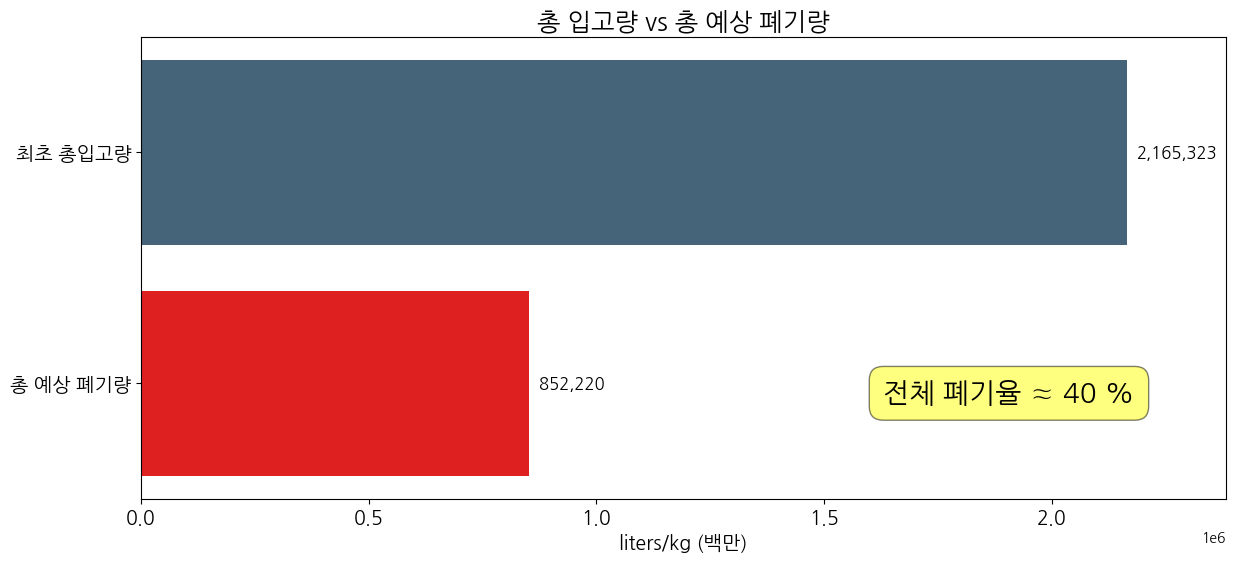

전체 폐기율: 39.36%
--- 연도별 요약 ---
           Total_Quantity    Total_Waste  Total_Waste_Rate
Prod_Year                                                 
2018             52195.93   23060.872262          0.441814
2019            537486.78  207178.933831          0.385459
2020            568655.78  228484.425428          0.401797
2021            544319.39  217947.721427          0.400404
2022            462664.86  175548.210293          0.379428


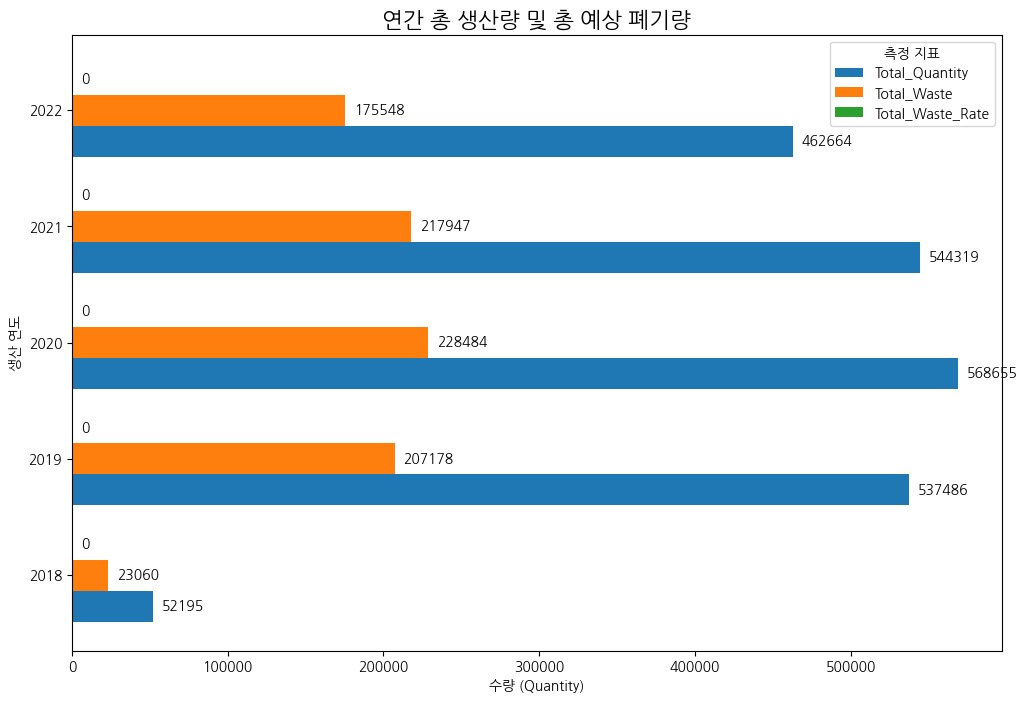

In [162]:
# 1. 시각화할 데이터 계산
total_quantity = df['Quantity'].sum()
total_waste = df['Expected_Waste_Qty'].sum()

# 데이터 레이블과 값 설정
labels = ['최초 총입고량', '총 예상 폐기량']
values = [total_quantity, total_waste]

cl = ['#3C6682', 'red']
# 2. 시각화
plt.figure(figsize=(14, 6))
# 가로 막대그래프 생성: plt.barh()
ax = sns.barplot(x=values, y=labels, palette=cl)

# 3. 그래프 꾸미기
plt.title('총 입고량 vs 총 예상 폐기량', fontsize=18)
plt.xlabel('liters/kg (백만)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(0, total_quantity * 1.1) # x축 여유 공간 확보


# 막대 위에 실제 숫자 값 표시
for i, v in enumerate(values):
    ax.text(v + (total_quantity * 0.01), i, f'{v:,.0f}', color='black', va='center', fontsize=12)

plt.text(0.8, 0.2,'전체 폐기율 ≈ 40 %', transform=ax.transAxes, ha='center', va='bottom', fontsize=20, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()

# 폐기율 계산 및 출력
overall_waste_rate = total_waste / total_quantity
print(f"전체 폐기율: {overall_waste_rate:.2%}")

# 1. 연도별로 총 생산량과 총 예상 폐기량을 계산
yearly_summary = df.groupby('Prod_Year').agg(
    Total_Quantity=('Quantity', 'sum'),
    Total_Waste=('Expected_Waste_Qty', 'sum')
)
yearly_summary['Total_Waste_Rate'] = yearly_summary['Total_Waste'] / yearly_summary['Total_Quantity']

print("--- 연도별 요약 ---")
print(yearly_summary)

# 2. pandas의 내장 plot 기능을 사용하여 그룹형 가로 막대그래프 생성
ax = yearly_summary.plot(kind='barh', figsize=(12, 8), width=0.8)

# 3. 그래프 꾸미기
plt.title('연간 총 생산량 및 총 예상 폐기량', fontsize=16)
plt.xlabel('수량 (Quantity)')
plt.ylabel('생산 연도')
plt.legend(title='측정 지표')

# 각 막대 위에 숫자 값 표시
for p in ax.patches:
    width = p.get_width()
    if width > 0: # 0보다 큰 값만 표시
        ax.text(width + (yearly_summary['Total_Quantity'].max() * 0.01), # 막대 오른쪽에
                p.get_y() + p.get_height() / 2,
                f'{int(width)}', # 정수로 표시
                va='center')

plt.show()


--- 제품별 평균 폐기율 분석 ---
  Product_Name Waste_Rate
3         Curd      0.49%
1   Buttermilk      0.46%
8       Paneer      0.46%
7         Milk      0.44%
6        Lassi      0.43%
5    Ice Cream      0.40%
9       Yogurt      0.39%
0       Butter      0.37%
2       Cheese      0.26%
4         Ghee      0.16%
-----------------------------------


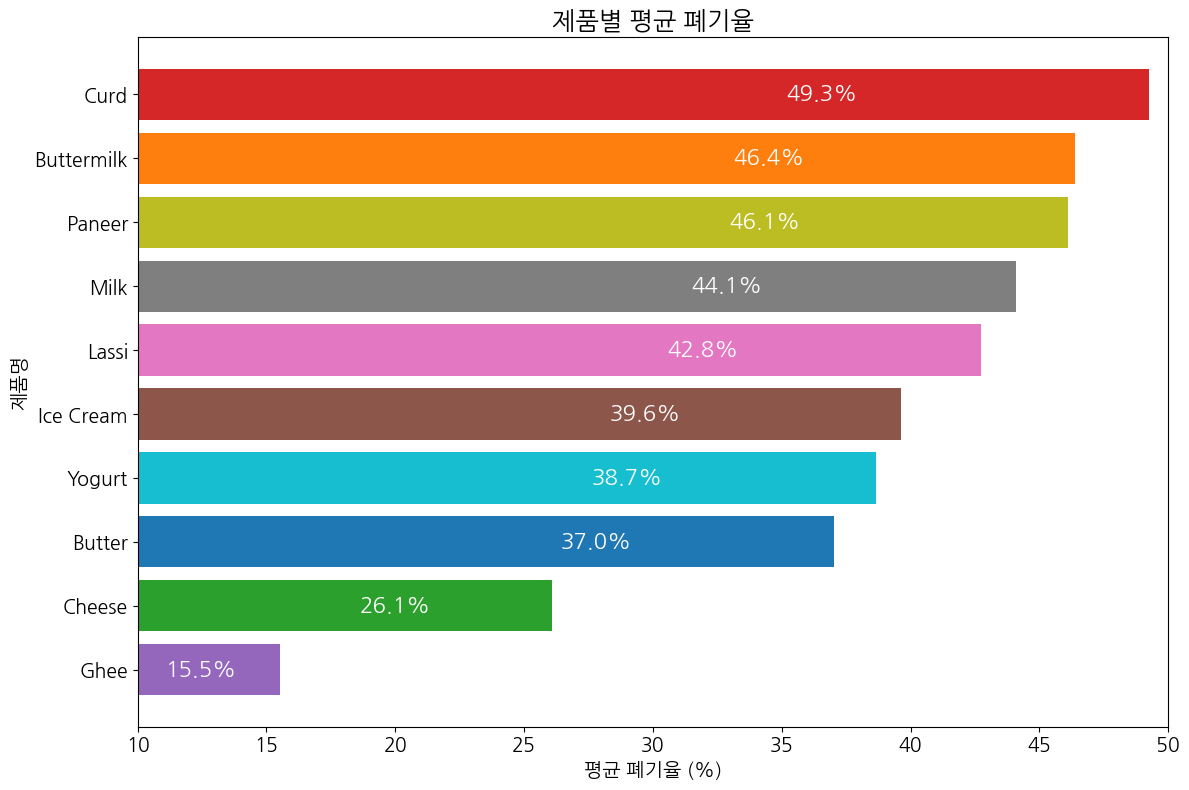

In [163]:
product_counts = df['Product_Name'].value_counts()

product_waste_analysis = df.groupby('Product_Name')['Waste_Rate'].mean().reset_index()

# 2. 폐기율이 높은 순서대로 정렬합니다.
product_waste_sorted = product_waste_analysis.sort_values(by='Waste_Rate', ascending=False)

print("--- 제품별 평균 폐기율 분석 ---")
# 폐기율을 퍼센트(%) 형태로 보기 좋게 바꿉니다.
product_waste_sorted['Waste_Rate'] = product_waste_sorted['Waste_Rate'].apply(lambda x: f"{x:.2f}%")
print(product_waste_sorted)
print("-" * 35)


# 3. 시각화: 폐기율 상위 10개 제품
# 시각화를 위해 정렬된 데이터에서 숫자 부분만 다시 가져옵니다.
top_products_to_plot = product_waste_analysis.sort_values(by='Waste_Rate', ascending=False)
my_colors = ['#D62728', '#FF7F0E', '#BCBD22', '#7F7F7F', '#E377C2', '#8C564B', '#17BECF', '#1F77B4', '#2CA02C', '#9467BD']
plt.figure(figsize=(12, 8))
bars = plt.barh(top_products_to_plot['Product_Name'], top_products_to_plot['Waste_Rate']*100, color=my_colors)

plt.title(f'제품별 평균 폐기율', fontsize=18)
plt.xlabel('평균 폐기율 (%)', fontsize=14)
plt.ylabel('제품명', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(10,50)
plt.gca().invert_yaxis() # 높은 순서대로 위에서부터 표시

# 막대그래프에 퍼센트(%) 값 표시
for bar in bars:
    width = bar.get_width()
    plt.text(bar.get_x() + bar.get_width()/1.4, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontsize=16, color='white', fontweight='extra bold')

plt.tight_layout()
plt.show()

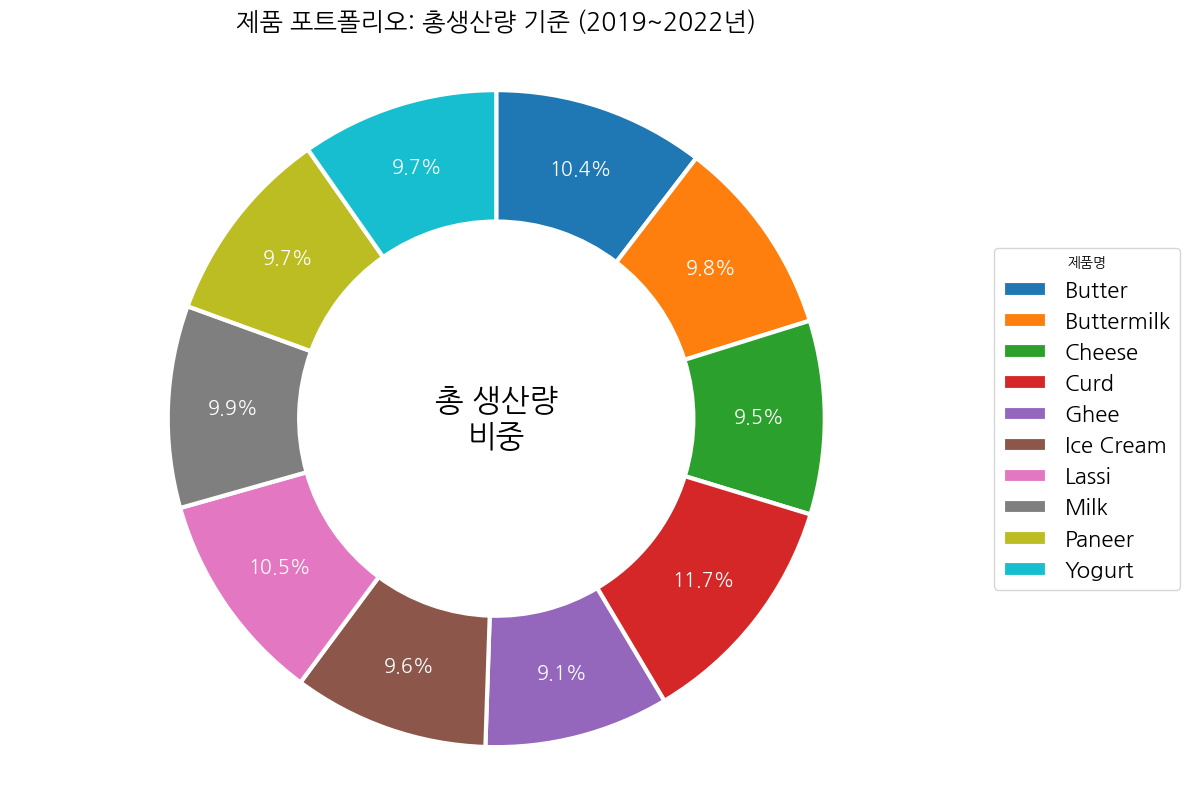

In [164]:
product_quantity = df.groupby('Product_Name')['Quantity'].sum()

fig, ax = plt.subplots(figsize=(12, 8)) # 범례 공간을 위해 가로 사이즈를 조금 늘렸습니다.

# 4. 파이 차트의 구성요소(wedges, autotexts)를 변수로 받습니다.
#    - labels 인자는 범례로 대체하기 위해 제거합니다.
wedges, _, autotexts = ax.pie(
    product_quantity,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    pctdistance=0.8,
    # 도넛 두께와 조각 사이 여백 설정
    wedgeprops={'width': 0.4, 'edgecolor': 'w', 'linewidth': 3}
)

# 5. 차트 제목 설정
ax.set_title("제품 포트폴리오: 총생산량 기준 (2019~2022년)", fontsize=18, pad=20)

# 6. 중앙 텍스트 추가
ax.text(0, 0, '총 생산량\n비중', # \n으로 줄바꿈
        ha='center',
        va='center',
        fontsize=22,
        fontweight='bold'
        )

# 7. 범례(Legend)를 사용하여 제품명을 검정색으로 표시
ax.legend(wedges, product_quantity.index,
            title="제품명",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1), # 그래프 오른쪽에 범례 배치
            fontsize=16)

# 8. 퍼센트(%) 글씨를 흰색, 굵게, 특정 사이즈로 설정
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(14)

# 9. 차트를 원형으로 유지하고 레이아웃 정리
ax.axis('equal')
plt.tight_layout()
plt.show()



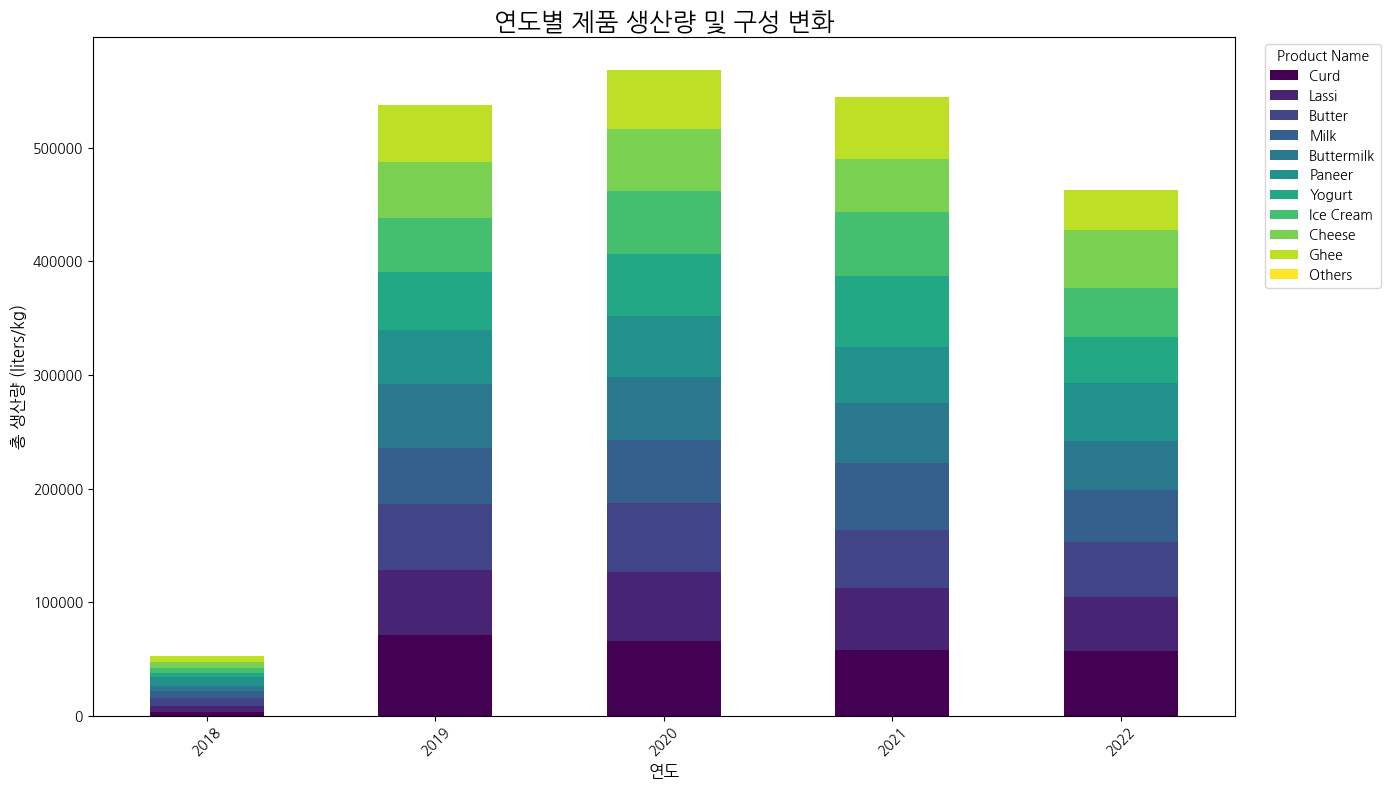

In [165]:
yearly_production = df.pivot_table(
    index='Prod_Year',
    columns='Product_Name',
    values='Quantity',
    aggfunc='sum'
).fillna(0)

# 3. (옵션) 생산량이 적은 제품은 'Others'로 묶어주면 그래프가 깔끔해집니다.
# 예: 상위 5개 제품 외에는 Others로 처리
top_n = 10
top_products = yearly_production.sum().nlargest(top_n).index
yearly_production['Others'] = yearly_production.drop(columns=top_products).sum(axis=1)
final_data = yearly_production[list(top_products) + ['Others']]


# 4. 누적 막대그래프(Stacked Bar Chart)로 시각화합니다.
final_data.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis' # 색상 테마 지정
)

plt.title('연도별 제품 생산량 및 구성 변화', fontsize=18)
plt.xlabel('연도', fontsize=12)
plt.ylabel('총 생산량 (liters/kg)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Product Name', bbox_to_anchor=(1.02, 1), loc='upper left') # 범례를 그래프 밖에 표시
plt.tight_layout()

# 통계검정

## 가설1: 대량생산 그룹과 소량생산 그룹의 폐기율 차이는 없다.

/tmp/ipython-input-549050051.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(all_products)) # 'Paired' 컬러맵 사용


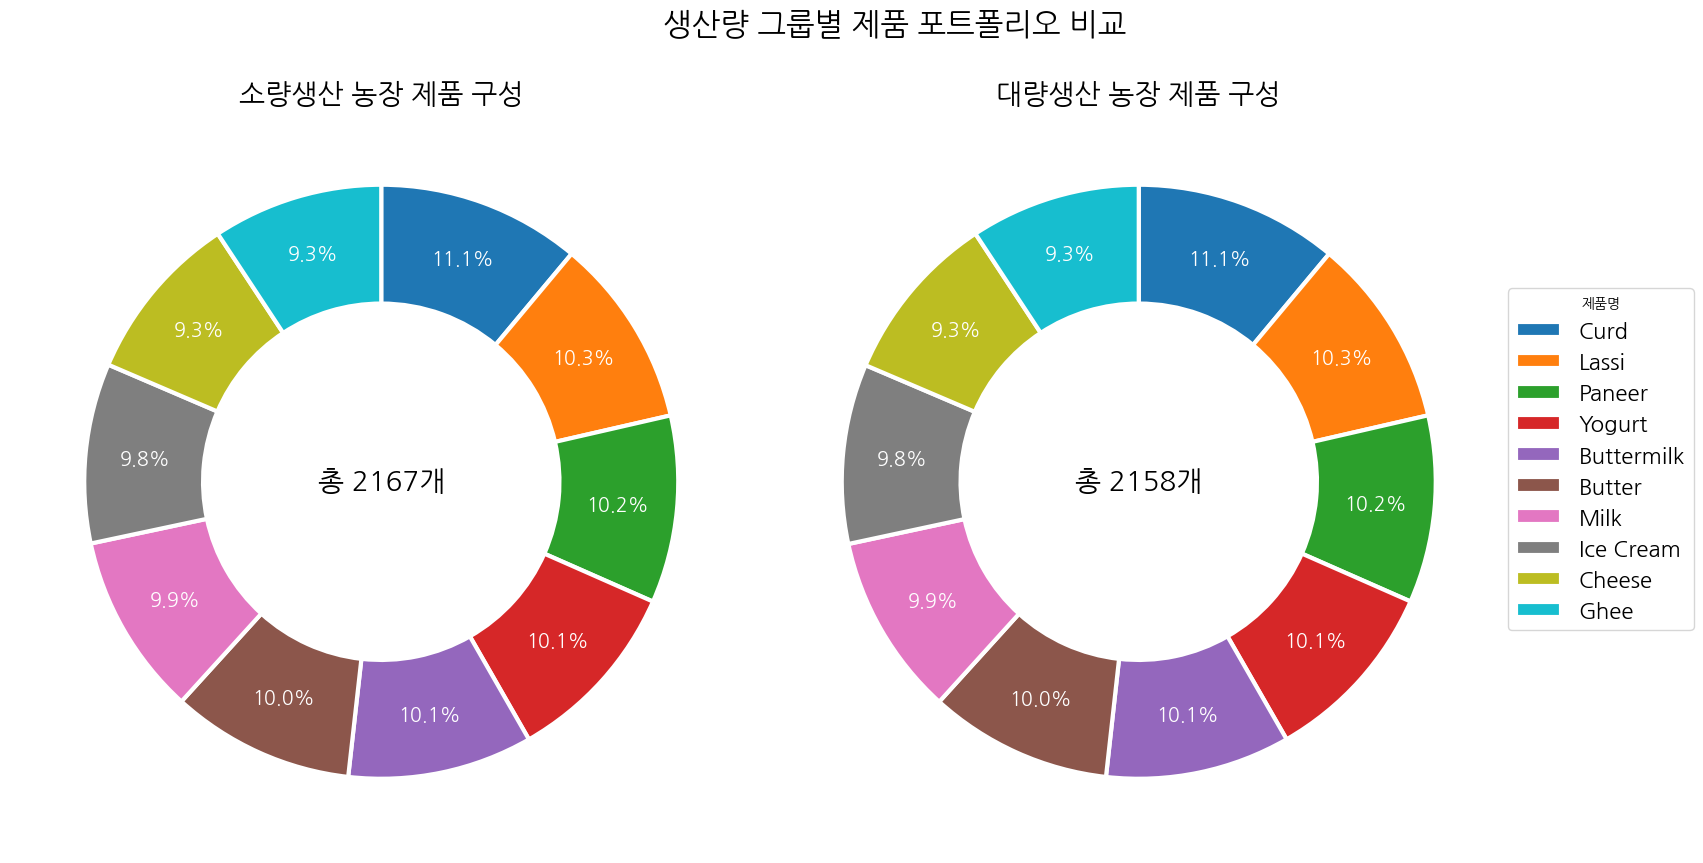

In [166]:
low_efficiency_group = df[df['Quantity_Group']=='소량생산 농장']
high_efficiency_group = df[df['Quantity_Group']=='대량생산 농장']

low_counts = low_efficiency_group['Product_Name'].value_counts()
high_counts = high_efficiency_group['Product_Name'].value_counts()

all_products = pd.concat([low_counts, high_counts]).index.unique()
colors = plt.cm.get_cmap('viridis', len(all_products)) # 'Paired' 컬러맵 사용
color_map = {product: colors(i) for i, product in enumerate(all_products)}

# 각 그룹 데이터에 맞는 색상 리스트를 생성합니다.
low_colors = [color_map[product] for product in low_counts.index]
high_colors = [color_map[product] for product in high_counts.index]


# 2. 그래프 객체 생성
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
ax1, ax2 = axes


# 3. 왼쪽 차트: 저효율 농장 (도넛 차트로 변경)
wedges1, _, autotexts1 = ax1.pie(
    low_counts,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    #colors=low_colors, # 통일된 색상 적용
    pctdistance=0.8,
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 3}
)
ax1.set_title('소량생산 농장 제품 구성', fontsize=20)

# 퍼센트 텍스트 스타일 지정
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(14)


# 4. 오른쪽 차트: 고효율 농장 (도넛 차트로 변경)
wedges2, _, autotexts2 = ax2.pie(
    high_counts,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    #colors=high_colors, # 통일된 색상 적용
    pctdistance=0.8,
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 3}
)
ax2.set_title('대량생산 농장 제품 구성', fontsize=20)

# 퍼센트 텍스트 스타일 지정
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(14)

# 5. 중앙 텍스트 및 전체 제목, 범례 추가
ax1.text(0, 0, f"총 {low_counts.sum()}개", ha='center', va='center', fontsize=20, fontweight='bold')
ax2.text(0, 0, f"총 {high_counts.sum()}개", ha='center', va='center', fontsize=20, fontweight='bold')

fig.suptitle('생산량 그룹별 제품 포트폴리오 비교', fontsize=22, y=1.0)
fig.legend(wedges1, low_counts.index, title="제품명", loc="center right", bbox_to_anchor=(0.95, 0.5), fontsize=16)

plt.tight_layout(rect=[0, 0, 0.85, 1]) # 범례 공간 확보
plt.show()

/tmp/ipython-input-3444053556.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity_Group', y='Waste_Rate', data=avg_waste_by_group, palette='coolwarm', order=efficiency_order)


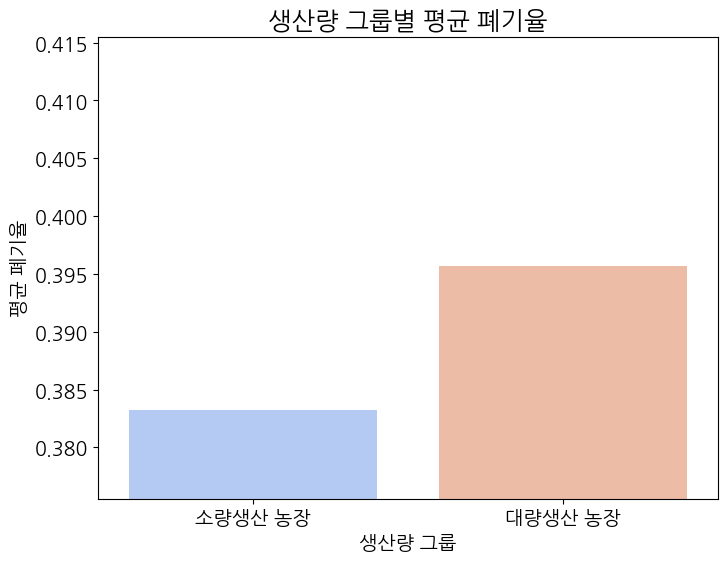

--- 생산량 그룹별 평균 폐기율 ---
  Quantity_Group  Waste_Rate
0        대량생산 농장    0.395727
1        소량생산 농장    0.383224

T-statistic: 1.2632
P-value: 0.2066
통계적으로 유의미한 차이가 없습니다 (p >= 0.05).


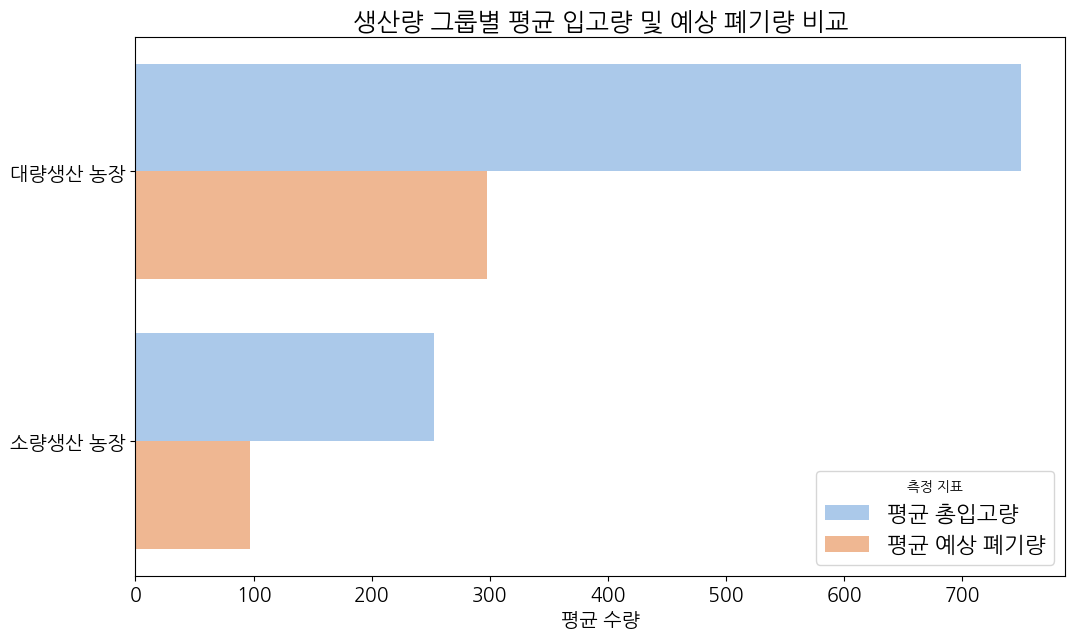

In [167]:
avg_waste_by_group = df.groupby('Quantity_Group')['Waste_Rate'].mean().reset_index()

efficiency_order = ['소량생산 농장', '대량생산 농장']

plt.figure(figsize=(8, 6))
sns.barplot(x='Quantity_Group', y='Waste_Rate', data=avg_waste_by_group, palette='coolwarm', order=efficiency_order)
plt.title('생산량 그룹별 평균 폐기율', fontsize=18)
plt.xlabel('생산량 그룹', fontsize=14)
plt.ylabel('평균 폐기율', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
min_val = avg_waste_by_group['Waste_Rate'].min()
plt.ylim(min_val * 0.98)

plt.show()

low_efficiency_group = df[df['Quantity_Group'] == '소량생산 농장']
high_efficiency_group = df[df['Quantity_Group'] == '대량생산 농장']
high_efficiency_group_waste = high_efficiency_group['Waste_Rate']
low_efficiency_group_waste = low_efficiency_group['Waste_Rate']
t_statistic, p_value = stats.ttest_ind(high_efficiency_group_waste, low_efficiency_group_waste, equal_var=False)


print("--- 생산량 그룹별 평균 폐기율 ---")
print(avg_waste_by_group)

print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("통계적으로 유의미한 차이가 있습니다 (p < 0.05).")
else:
    print("통계적으로 유의미한 차이가 없습니다 (p >= 0.05).")


low_q_mean = low_efficiency_group["Quantity"].mean()
low_w_mean = low_efficiency_group["Expected_Waste_Qty"].mean()
high_q_mean = high_efficiency_group["Quantity"].mean()
high_w_mean = high_efficiency_group["Expected_Waste_Qty"].mean()

plot_data = pd.DataFrame({
    'Efficiency_Group': ['대량생산 농장', '대량생산 농장', '소량생산 농장', '소량생산 농장'],
    'Metric': ['평균 총입고량', '평균 예상 폐기량', '평균 총입고량', '평균 예상 폐기량'],
    'Value': [high_q_mean, high_w_mean, low_q_mean, low_w_mean]
})

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_data,
    y='Efficiency_Group',
    x='Value',
    hue='Metric',
    palette='pastel'
)

plt.title('생산량 그룹별 평균 입고량 및 예상 폐기량 비교', fontsize=18)
plt.xlabel('평균 수량', fontsize=14)
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='측정 지표', fontsize=16)
plt.show()

## 가설2: 소 한마리당 생산량이 많은 그룹과 적은 그룹의 평균폐기율 차이가 없을 것이다.

### 정규성검정

저효율 농장: p=5.105723327400699e-35
저효율 농장: stat=0.9030707690252555
고효율 농장: p=1.38211342062668e-34
고효율 농장: stat=0.9056674628780698


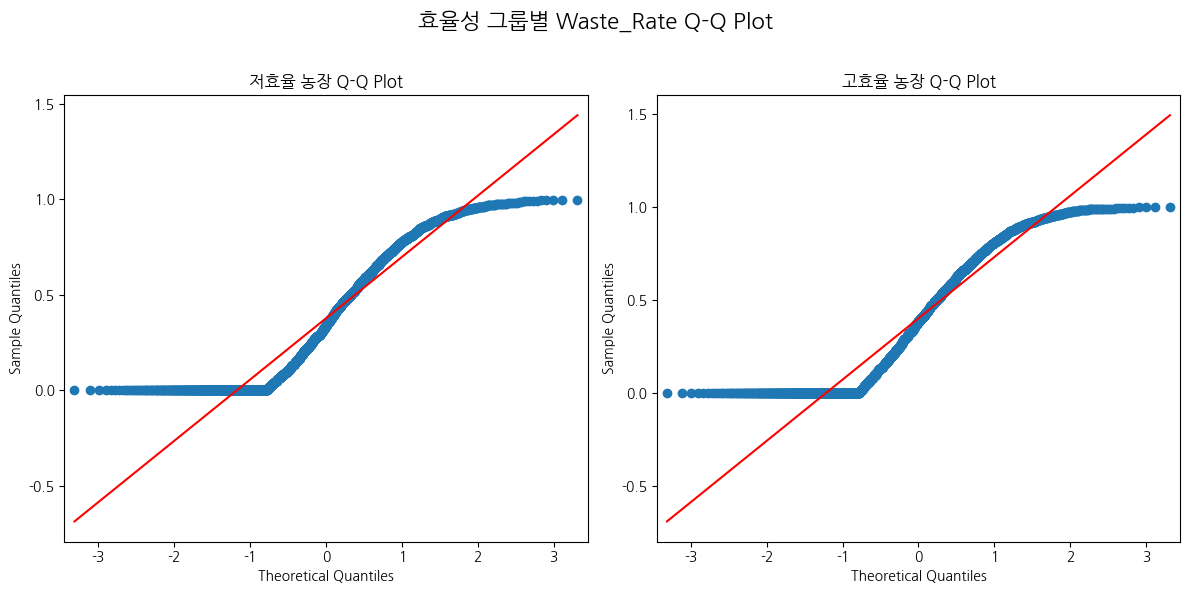

In [168]:
for group in df['Efficiency_Group_Product'].unique():
    stat, p = stats.shapiro(df[df['Efficiency_Group_Product']==group]['Waste_Rate'])
    print(f'{group}: p={p}')
    print(f'{group}: stat={stat}')



# 1. 각 그룹의 데이터 분리
low_eff_waste = df[df['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate'].dropna()
high_eff_waste = df[df['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate'].dropna()

# 2. 1행 2열의 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 3. 각 축에 Q-Q 플롯 그리기
sm.qqplot(low_eff_waste, line='s', ax=axes[0])
axes[0].set_title('저효율 농장 Q-Q Plot')

sm.qqplot(high_eff_waste, line='s', ax=axes[1])
axes[1].set_title('고효율 농장 Q-Q Plot')

fig.suptitle('효율성 그룹별 Waste_Rate Q-Q Plot', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitle과 겹치지 않게 조정
plt.show()

### 등분산성 검정

/tmp/ipython-input-2338748985.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Efficiency_Group_Product', y='Waste_Rate', data=df, palette='coolwarm')


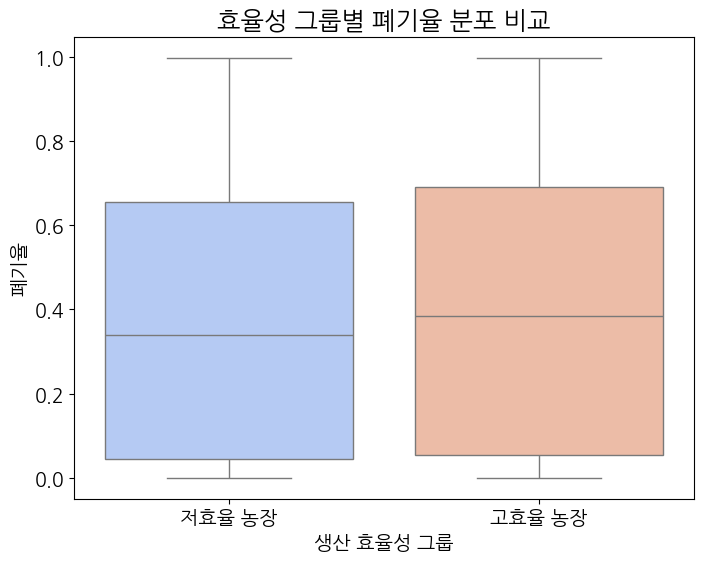

Levene 검정 p-value: 0.0806
▶ 결론: 두 그룹의 분산에 유의미한 차이가 없습니다 (등분산성 만족).


In [169]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Efficiency_Group_Product', y='Waste_Rate', data=df, palette='coolwarm')
plt.title('효율성 그룹별 폐기율 분포 비교', fontsize=18)
plt.xlabel('생산 효율성 그룹', fontsize=14)
plt.ylabel('폐기율', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

high_efficiency_waste = df[df['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate'].dropna()
low_efficiency_waste = df[df['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate'].dropna()

# Levene 검정
statistic, p_value = stats.levene(high_efficiency_waste, low_efficiency_waste)

print(f"Levene 검정 p-value: {p_value:.4f}")

if p_value < 0.05:
    print("▶ 결론: 두 그룹의 분산은 통계적으로 유의미하게 다릅니다 (등분산성 위배).")
else:
    print("▶ 결론: 두 그룹의 분산에 유의미한 차이가 없습니다 (등분산성 만족).")

### t-test 및 시각화

/tmp/ipython-input-2528586253.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Efficiency_Group_Product', y='Waste_Rate', data=avg_waste_by_group, palette='coolwarm', order=efficiency_order)


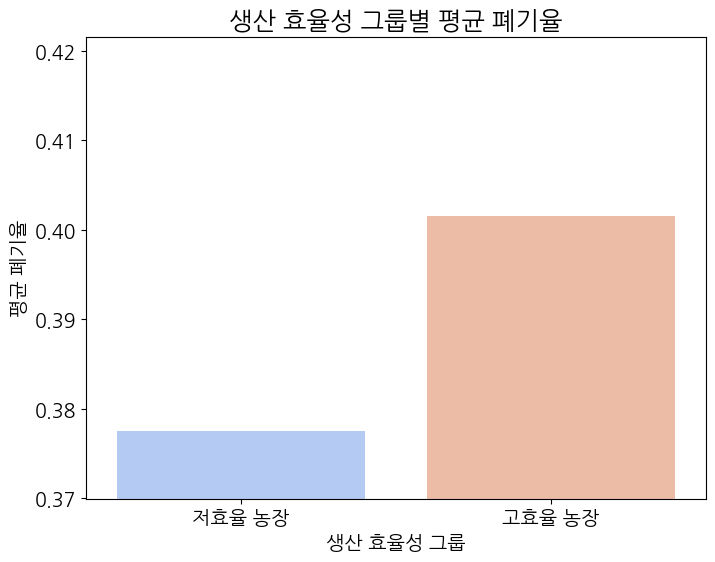

--- 효율성 그룹별 평균 폐기율 ---
  Efficiency_Group_Product  Waste_Rate
0                   고효율 농장    0.401477
1                   저효율 농장    0.377498

T-statistic: 2.4235
P-value: 0.0154
통계적으로 유의미한 차이가 있습니다 (p < 0.05).


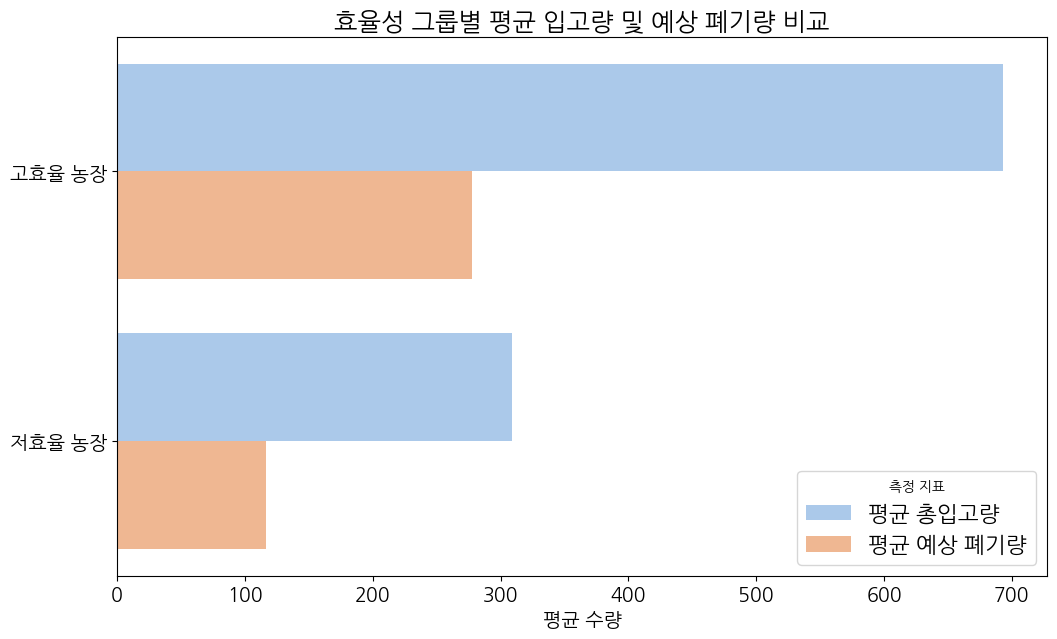

In [170]:
avg_waste_by_group = df.groupby('Efficiency_Group_Product')['Waste_Rate'].mean().reset_index()

efficiency_order = ['저효율 농장', '고효율 농장']

plt.figure(figsize=(8, 6))
sns.barplot(x='Efficiency_Group_Product', y='Waste_Rate', data=avg_waste_by_group, palette='coolwarm', order=efficiency_order)
plt.title('생산 효율성 그룹별 평균 폐기율', fontsize=18)
plt.xlabel('생산 효율성 그룹', fontsize=14)
plt.ylabel('평균 폐기율', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
min_val = avg_waste_by_group['Waste_Rate'].min()
plt.ylim(min_val * 0.98)

plt.show()

high_efficiency_group_waste = df[df['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate']
low_efficiency_group_waste = df[df['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate']
t_statistic, p_value = stats.ttest_ind(high_efficiency_group_waste, low_efficiency_group_waste, equal_var=False)


print("--- 효율성 그룹별 평균 폐기율 ---")
print(avg_waste_by_group)

print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("통계적으로 유의미한 차이가 있습니다 (p < 0.05).")
else:
    print("통계적으로 유의미한 차이가 없습니다 (p >= 0.05).")

# =============================

low_efficiency_group = df[df['Efficiency_Group_Product']=='저효율 농장']
high_efficiency_group = df[df['Efficiency_Group_Product']=='고효율 농장']

low_q_mean = low_efficiency_group["Quantity"].mean()
low_w_mean = low_efficiency_group["Expected_Waste_Qty"].mean()
high_q_mean = high_efficiency_group["Quantity"].mean()
high_w_mean = high_efficiency_group["Expected_Waste_Qty"].mean()

plot_data = pd.DataFrame({
    'Efficiency_Group': ['고효율 농장', '고효율 농장', '저효율 농장', '저효율 농장'],
    'Metric': ['평균 총입고량', '평균 예상 폐기량', '평균 총입고량', '평균 예상 폐기량'],
    'Value': [high_q_mean, high_w_mean, low_q_mean, low_w_mean]
})

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_data,
    y='Efficiency_Group',
    x='Value',
    hue='Metric',
    palette='pastel'
)

plt.title('효율성 그룹별 평균 입고량 및 예상 폐기량 비교', fontsize=18)
plt.xlabel('평균 수량', fontsize=14)
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='측정 지표', fontsize=16)
plt.show()

### 비모수검정

In [171]:
high_efficiency_waste = df[df['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate'].dropna()
low_efficiency_waste = df[df['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate'].dropna()

# 만-휘트니 U 검정
statistic, p_value = stats.mannwhitneyu(high_efficiency_waste, low_efficiency_waste, alternative='two-sided')

print(f"Mann-Whitney U 검정 통계량: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\n▶ 결론: 두 그룹의 폐기율 분포에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("\n▶ 결론: 두 그룹의 폐기율 분포에 유의미한 차이가 있다고 말할 수 없습니다.")

Mann-Whitney U 검정 통계량: 2426479.5000
P-value: 0.0307

▶ 결론: 두 그룹의 폐기율 분포에는 통계적으로 유의미한 차이가 있습니다.


##가설2-1: 두 그룹의 평균 가격점수에 차이가 없다

### t-test 및 시각화 (+Levene검정)

T-statistic: -0.1119
P-value: 0.9109

--- 최종 결론 ---
p-value는 0.9109로, 유의수준 0.05보다 큽니다.
▶ 귀무가설 기각 실패: 두 그룹의 평균 가격 점수에 유의미한 차이가 있다고 말할 수 없습니다.


/tmp/ipython-input-1885721707.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Efficiency_Group_Product', y='Price_Score', data=df, palette='coolwarm',


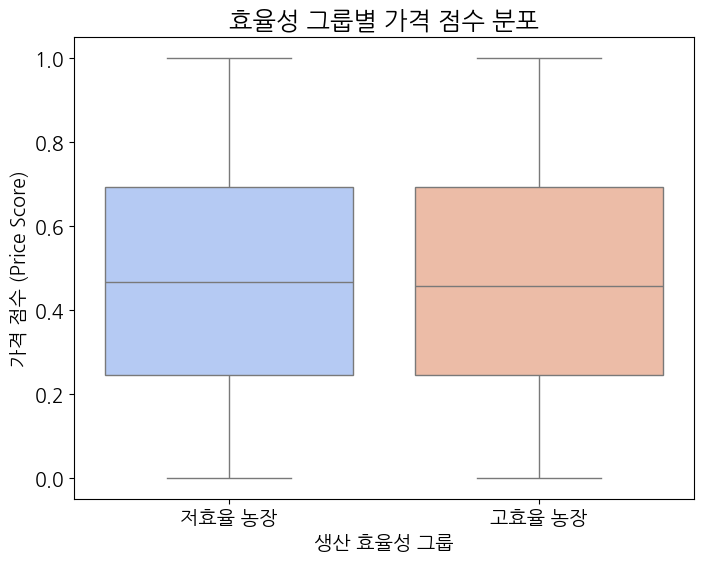

Levene 검정 p-value: 0.6473
▶ 결론: 두 그룹의 분산에 유의미한 차이가 없습니다 (등분산성 만족).


In [172]:
high_efficiency_scores = df[df['Efficiency_Group_Product'] == '고효율 농장']['Price_Score']
low_efficiency_scores = df[df['Efficiency_Group_Product'] == '저효율 농장']['Price_Score']

# 독립표본 T-검정 수행
t_statistic, p_value = stats.ttest_ind(
    high_efficiency_scores.dropna(),
    low_efficiency_scores.dropna()
)

print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

print("\n--- 최종 결론 ---")
if p_value < 0.05:
    print(f"p-value는 {p_value:.4f}로, 유의수준 0.05보다 작습니다.")
    print("▶ 귀무가설 기각: 두 그룹의 평균 가격 점수에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print(f"p-value는 {p_value:.4f}로, 유의수준 0.05보다 큽니다.")
    print("▶ 귀무가설 기각 실패: 두 그룹의 평균 가격 점수에 유의미한 차이가 있다고 말할 수 없습니다.")

# 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(x='Efficiency_Group_Product', y='Price_Score', data=df, palette='coolwarm',
            order=['저효율 농장', '고효율 농장']) # 순서 고정

plt.title('효율성 그룹별 가격 점수 분포', fontsize=18)
plt.xlabel('생산 효율성 그룹', fontsize=14)
plt.ylabel('가격 점수 (Price Score)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# Levene 검정
high_efficiency_waste = df[df['Efficiency_Group_Product'] == '고효율 농장']['Price_Score'].dropna()
low_efficiency_waste = df[df['Efficiency_Group_Product'] == '저효율 농장']['Price_Score'].dropna()

statistic, p_value = stats.levene(high_efficiency_waste, low_efficiency_waste)

print(f"Levene 검정 p-value: {p_value:.4f}")

if p_value < 0.05:
    print("▶ 결론: 두 그룹의 분산은 통계적으로 유의미하게 다릅니다 (등분산성 위배).")
else:
    print("▶ 결론: 두 그룹의 분산에 유의미한 차이가 없습니다 (등분산성 만족).")

## 가설2 보충 내용: 채널별 평균 폐기율 차이가 없다

### 시각화

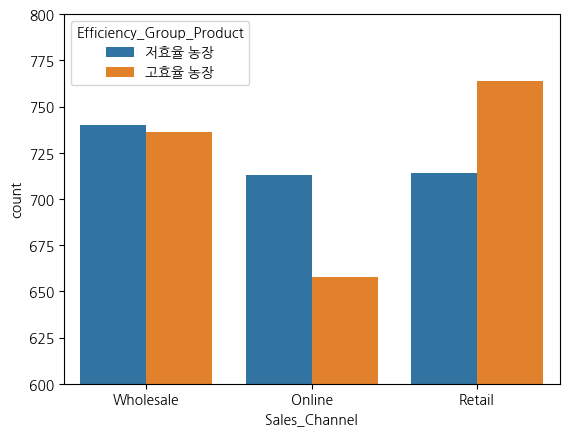

In [173]:
sns.countplot(data=df, x='Sales_Channel', hue='Efficiency_Group_Product')
plt.ylim(600,800)
plt.show()

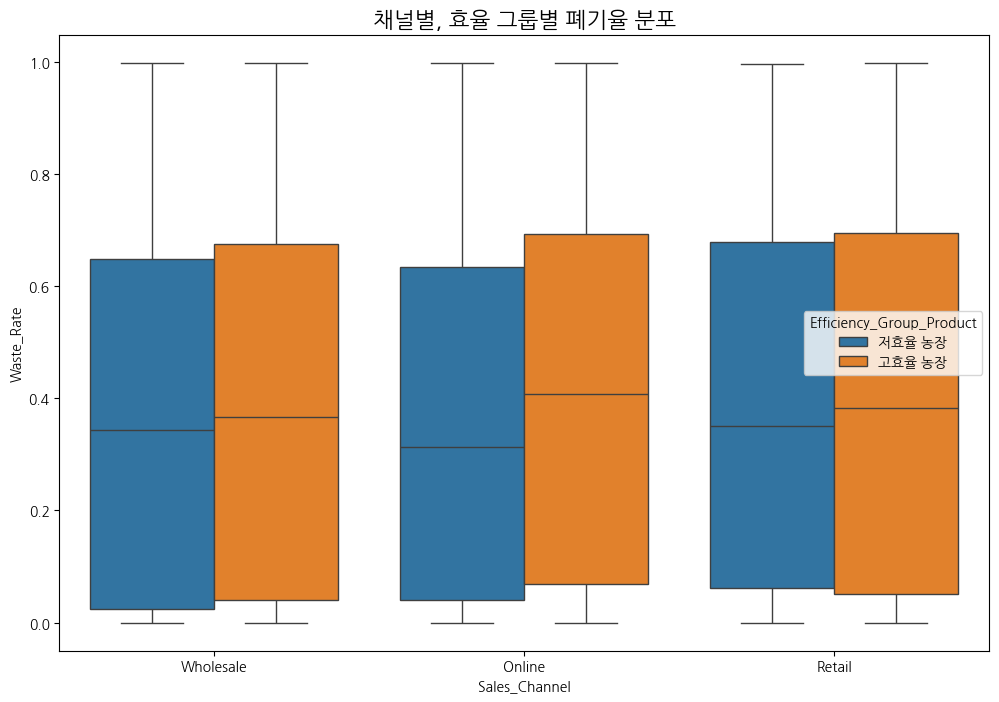

In [174]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Sales_Channel', y='Waste_Rate', hue='Efficiency_Group_Product')
plt.title('채널별, 효율 그룹별 폐기율 분포', fontsize=16)
plt.show()

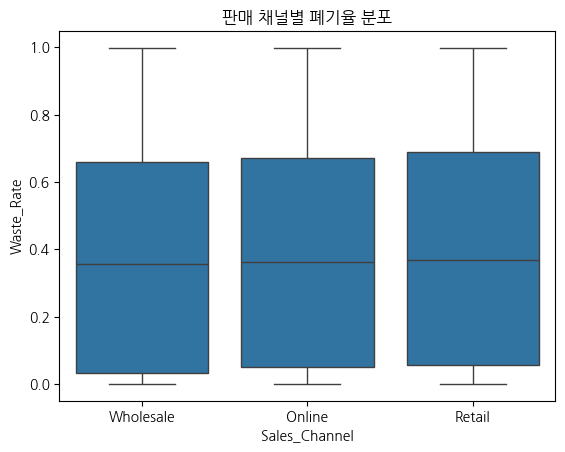

P-value: 0.6382465886697715


In [175]:
# 1. 시각화 (박스 플롯)
sns.boxplot(data=df, x='Sales_Channel', y='Waste_Rate')
plt.title('판매 채널별 폐기율 분포')
plt.show()

# 2. 통계 검정 (ANOVA)
wholesale_waste = df[df['Sales_Channel'] == 'Wholesale']['Waste_Rate']
online_waste = df[df['Sales_Channel'] == 'Online']['Waste_Rate']
retail_waste = df[df['Sales_Channel'] == 'Retail']['Waste_Rate']

f_stat, p_value = f_oneway(wholesale_waste, online_waste, retail_waste)
print(f"P-value: {p_value}")

온라인 판매 채널에서 저효율 농장과 고효율 농장의 평균 폐기율 차이가 큼

### 온라인 판매 채널 내 효율성그룹 비교

#### 시각화

                          Waste_Rate
Efficiency_Group_Product            
저효율 농장                      0.363743
고효율 농장                      0.412823


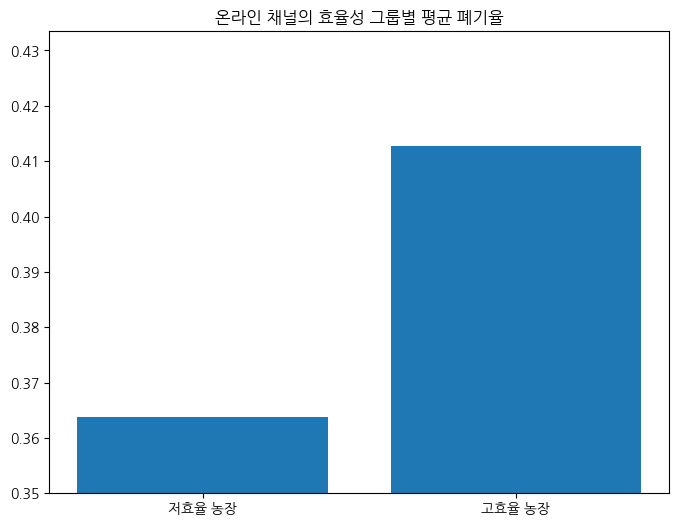

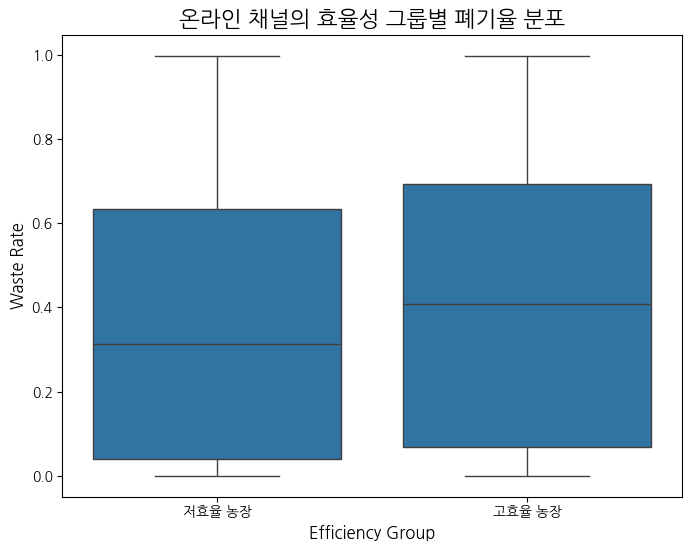

In [176]:
# 1. Online 채널 데이터만 필터링합니다.
# df는 기존에 사용하시던 전체 데이터프레임입니다.
df_online = df[df['Sales_Channel'] == 'Online'].copy()
df_online_group = df_online.groupby('Efficiency_Group_Product')[['Waste_Rate']].mean().sort_values(by='Waste_Rate')
print(df_online_group)
plt.figure(figsize=(8, 6))
plt.bar(['저효율 농장', '고효율 농장'], df_online_group['Waste_Rate'])
plt.ylim(0.35)
plt.title('온라인 채널의 효율성 그룹별 평균 폐기율')
plt.show()

# 2. 박스 플롯을 생성합니다.
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_online,
            x='Efficiency_Group_Product',
            y='Waste_Rate',
            order=['저효율 농장', '고효율 농장']) # 그룹 순서 지정

# 3. 그래프 제목과 라벨을 추가합니다. (한글 폰트가 없는 환경을 위해 영문으로 작성)
plt.title('온라인 채널의 효율성 그룹별 폐기율 분포', fontsize=16)
plt.xlabel('Efficiency Group', fontsize=12)
plt.ylabel('Waste Rate', fontsize=12)

# 4. 그래프를 화면에 표시합니다.
plt.show()

#### t-test

In [177]:
# 1. Online 채널 데이터만 필터링
df_online = df[df['Sales_Channel'] == 'Online'].copy()

# 2. Online 내에서 고효율 vs 저효율 그룹 분리
high_eff_online = df_online[df_online['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate']
low_eff_online = df_online[df_online['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate']

# 3. t-test 실행
t_stat, p_value = ttest_ind(high_eff_online, low_eff_online)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value for t-test within Retail channel: {p_value:.4f}")

T-statistic: 2.8283
P-value for t-test within Retail channel: 0.0047


## 가설2-2: 온라인채널에서 저효율농장과 고효율농장의 생산량 대비 평균 총매출 차이가 없다

### 시각화

### t-test

In [178]:
df_online = df[df['Sales_Channel']=='Online'].copy()

df_online['Revenue_per_Qty'] = df_online['Approx_Total_Revenue'] / df_online['Quantity']
df_online['Revenue_per_Cow'] = df_online['Approx_Total_Revenue'] / df_online['Number_of_Cows']

avg_waste_by_group = df_online.groupby('Efficiency_Group_Product')['Revenue_per_Qty'].mean().reset_index()

low_efficiency_group = df_online[df_online['Efficiency_Group_Product'] == '저효율 농장']
high_efficiency_group = df_online[df_online['Efficiency_Group_Product'] == '고효율 농장']
high_efficiency_group_Revenue = high_efficiency_group['Revenue_per_Qty']
low_efficiency_group_Revenue = low_efficiency_group['Revenue_per_Qty']
t_statistic, p_value = stats.ttest_ind(high_efficiency_group_Revenue, low_efficiency_group_Revenue, equal_var=False)


print("--- 효율성 그룹별 평균 매출 ---")
print(avg_waste_by_group)

print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("통계적으로 유의미한 차이가 있습니다 (p < 0.05).")
else:
    print("통계적으로 유의미한 차이가 없습니다 (p >= 0.05).")

--- 효율성 그룹별 평균 매출 ---
  Efficiency_Group_Product  Revenue_per_Qty
0                   고효율 농장        25.520343
1                   저효율 농장        28.966946

T-statistic: -2.9755
P-value: 0.0030
통계적으로 유의미한 차이가 있습니다 (p < 0.05).


## 가설2-3: 효율성 그룹별 유통기한 차이

T-statistic: -0.1009
P-value: 0.9197


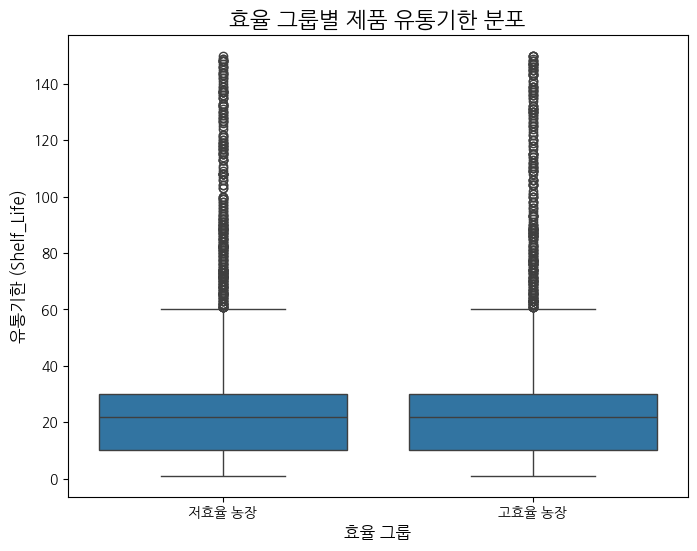

In [179]:
# 1. 두 그룹으로 데이터 분리
high_eff_shelf_life = df[df['Efficiency_Group_Product'] == '고효율 농장']['Shelf_Life']
low_eff_shelf_life = df[df['Efficiency_Group_Product'] == '저효율 농장']['Shelf_Life']

# 2. t-test 실행
t_stat, p_value = ttest_ind(high_eff_shelf_life, low_eff_shelf_life)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 3. 시각화 (박스 플롯)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Efficiency_Group_Product', y='Shelf_Life')
plt.title('효율 그룹별 제품 유통기한 분포', fontsize=16)
plt.xlabel('효율 그룹', fontsize=12)
plt.ylabel('유통기한 (Shelf_Life)', fontsize=12)
plt.show()

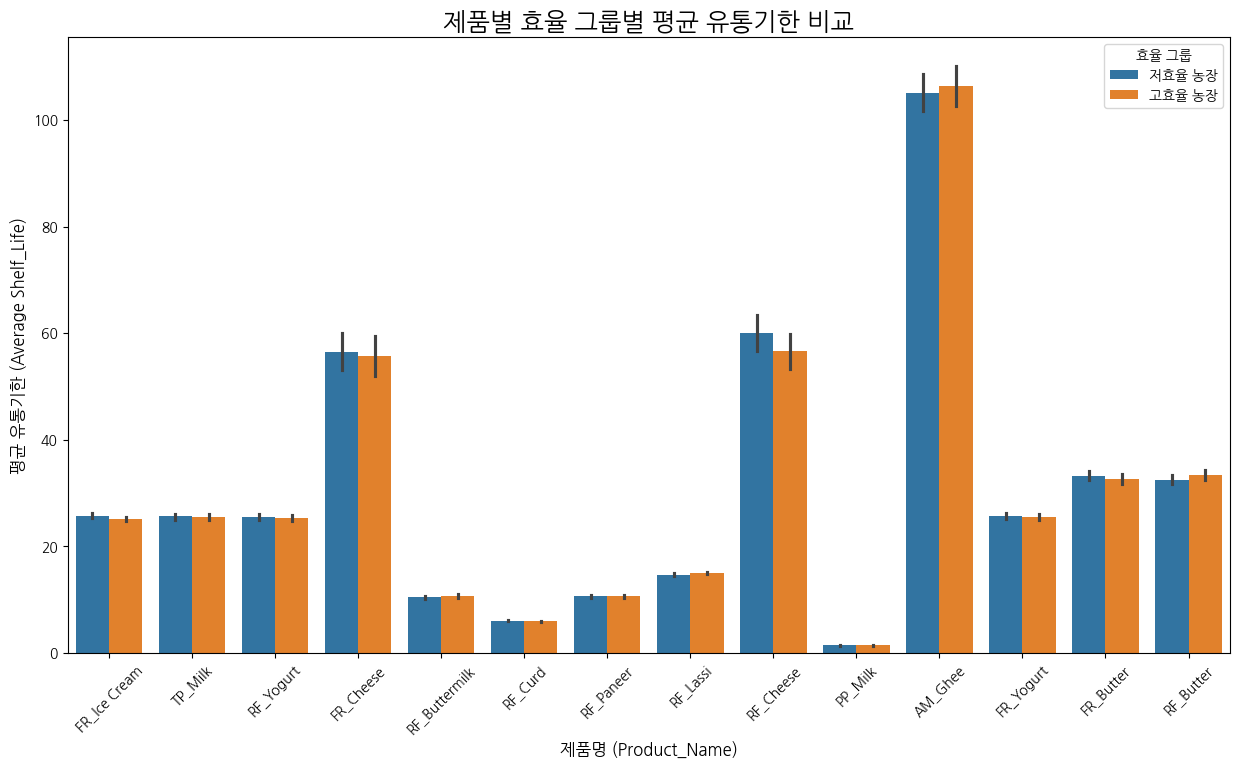

In [180]:
# 그래프 크기 설정
plt.figure(figsize=(15, 8))

# 그룹화된 막대그래프 생성
sns.barplot(data=df,
            x='Product_Profile',
            y='Shelf_Life',
            hue='Efficiency_Group_Product')

# 그래프 제목 및 라벨 설정
plt.title('제품별 효율 그룹별 평균 유통기한 비교', fontsize=18)
plt.xlabel('제품명 (Product_Name)', fontsize=12)
plt.ylabel('평균 유통기한 (Average Shelf_Life)', fontsize=12)
plt.xticks(rotation=45) # 제품 이름이 겹치지 않도록 글자 회전
plt.legend(title='효율 그룹')

# 그래프 표시
plt.show()

In [181]:
from scipy.stats import ttest_ind

# 전체 제품 목록 가져오기
products = df['Product_Name'].unique()

print("--- 제품별 유통기한 차이 t-test 결과 ---")

# 각 제품별로 반복하여 t-test 실행
for product in products:
    # 해당 제품 데이터만 필터링
    df_product = df[df['Product_Name'] == product]

    # 고효율/저효율 그룹으로 데이터 분리
    high_eff = df_product[df_product['Efficiency_Group_Product'] == '고효율 농장']['Shelf_Life']
    low_eff = df_product[df_product['Efficiency_Group_Product'] == '저효율 농장']['Shelf_Life']

    # t-test 실행
    t_stat, p_value = ttest_ind(high_eff, low_eff)

    # 결과 출력
    print(f"\n제품: {product}")
    print(f"P-value: {p_value:.4f}")

    # 유의수준 0.05 기준으로 결과 해석
    if p_value < 0.05:
        print(">> 결론: 두 그룹 간 유의미한 차이가 있습니다.")
    else:
        print(">> 결론: 두 그룹 간 유의미한 차이가 없습니다.")

--- 제품별 유통기한 차이 t-test 결과 ---

제품: Ice Cream
P-value: 0.0221
>> 결론: 두 그룹 간 유의미한 차이가 있습니다.

제품: Milk
P-value: 0.9908
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Yogurt
P-value: 0.5434
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Cheese
P-value: 0.2071
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Buttermilk
P-value: 0.2227
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Curd
P-value: 0.5779
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Paneer
P-value: 0.9556
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Lassi
P-value: 0.1758
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Ghee
P-value: 0.6602
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.

제품: Butter
P-value: 0.9123
>> 결론: 두 그룹 간 유의미한 차이가 없습니다.


In [182]:
df_online.groupby(['Product_Profile', 'Efficiency_Group_Product'])['Shelf_Life'].mean()

Product_Profile  Efficiency_Group_Product
AM_Ghee          고효율 농장                      105.518519
                 저효율 농장                      104.253968
FR_Butter        고효율 농장                       32.896552
                 저효율 농장                       33.743590
FR_Cheese        고효율 농장                       54.588235
                 저효율 농장                       56.928571
FR_Ice Cream     고효율 농장                       25.212121
                 저효율 농장                       25.902778
FR_Yogurt        고효율 농장                       25.774194
                 저효율 농장                       25.870968
PP_Milk          고효율 농장                        1.454545
                 저효율 농장                        1.368421
RF_Butter        고효율 농장                       33.424242
                 저효율 농장                       32.285714
RF_Buttermilk    고효율 농장                       10.900000
                 저효율 농장                       10.550000
RF_Cheese        고효율 농장                       55.142857
                 저효율 농장                       58.363636
RF_Curd          고효율 농장                        5.926471
                 저효율 농장                        5.976190
RF_Lassi         고효율 농장                       14.764706
                 저효율 농장                       14.863158
RF_Paneer        고효율 농장                       10.442623
                 저효율 농장                       10.965517
RF_Yogurt        고효율 농장                       25.281250
                 저효율 농장                       24.937500
TP_Milk          고효율 농장                       25.484848
                 저효율 농장                       25.718750
Name: Shelf_Life, dtype: float64

# 머신러닝

## 지도학습

### 회귀 모델

#### XGB-reg

--- XGBoost 모델 성능 ---
R-squared (R²): -0.0437
Mean Absolute Error (MAE): 0.2812
Mean Squared Error (MSE): 0.1089


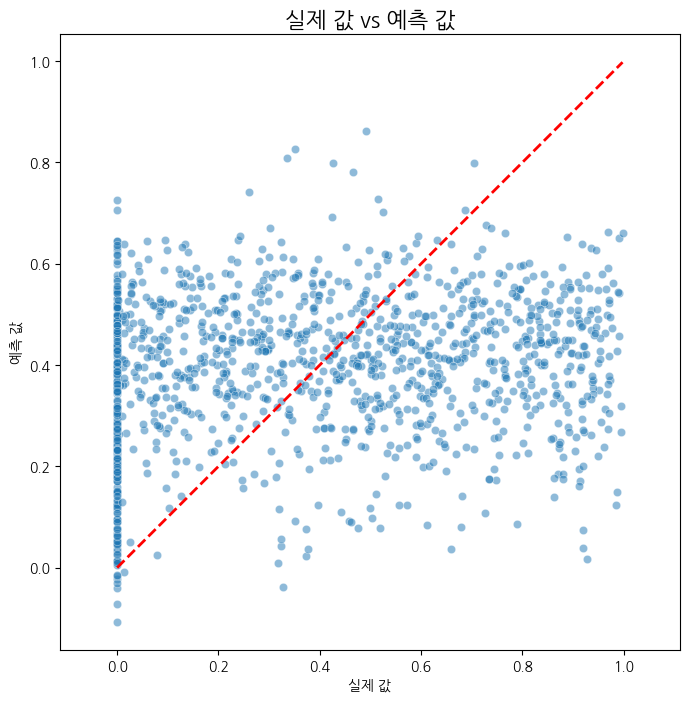

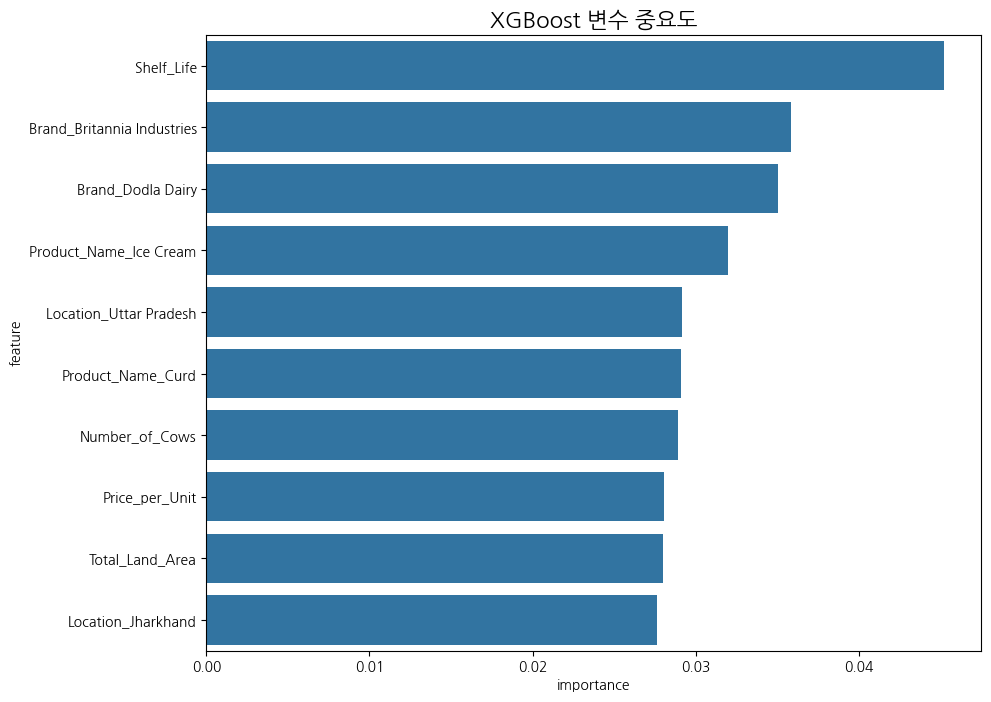

['Shelf_Life', 'Brand_Britannia Industries', 'Brand_Dodla Dairy', 'Product_Name_Ice Cream', 'Location_Uttar Pradesh', 'Product_Name_Curd', 'Number_of_Cows', 'Price_per_Unit', 'Total_Land_Area', 'Location_Jharkhand', 'Brand_Sudha', 'Location_Chandigarh', 'Total_Value', 'Location_Delhi', 'Reorder_Quantity', 'Location_West Bengal', 'Brand_Passion Cheese', 'Product_Name_Milk', 'Product_Name_Buttermilk', 'Location_Kerala', 'Brand_Raj', 'Minimum_Stock_Threshold', 'Location_Maharashtra', 'Product_Name_Paneer', 'Product_Name_Ghee', 'Location_Telangana', 'Efficiency_Group_Product_저효율 농장', 'Product_Name_Yogurt', 'Product_Name_Lassi', 'Location_Karnataka', 'Location_Tamil Nadu', 'Brand_Mother Dairy', 'Location_Rajasthan', 'Location_Gujarat', 'Brand_Palle2patnam', 'Brand_Dynamix Dairies', 'Location_Madhya Pradesh', 'Product_Name_Cheese', 'Brand_Warana', 'Location_Haryana', 'Brand_Parag Milk Foods']


In [183]:
y = df['Waste_Rate']

features = [
    'Total_Value', 'Price_per_Unit', 'Total_Land_Area', 'Reorder_Quantity', 'Minimum_Stock_Threshold', 'Number_of_Cows', 'Brand', 'Product_Name', 'Shelf_Life', 'Location', 'Efficiency_Group_Product'
]
X_raw = df[features]
X = pd.get_dummies(X_raw, drop_first=True)

a = ['Shelf_Life', 'Brand_Dodla Dairy', 'Location_Uttar Pradesh', 'Product_Name_Cheese', 'Product_Name_Paneer', 'Brand_Mother Dairy', 'Brand_Palle2patnam', 'Brand_Sudha', 'Brand_Raj', 'Location_Rajasthan', 'Brand_Britannia Industries', 'Location_Telangana', 'Location_Jharkhand', 'Product_Name_Yogurt', 'Efficiency_Group_Product_저효율 농장', 'Location_Maharashtra', 'Product_Name_Ice Cream', 'Product_Name_Lassi', 'Reorder_Quantity', 'Minimum_Stock_Threshold', 'Location_Tamil Nadu', 'Total_Land_Area', 'Price_per_Unit', 'Location_Gujarat', 'Number_of_Cows', 'Product_Name_Buttermilk', 'Brand_Passion Cheese', 'Location_Kerala', 'Location_Chandigarh', 'Location_West Bengal', 'Product_Name_Milk', 'Location_Madhya Pradesh', 'Product_Name_Curd', 'Location_Delhi', 'Location_Karnataka', 'Total_Value', 'Location_Haryana', 'Brand_Parag Milk Foods', 'Brand_Dynamix Dairies', 'Brand_Warana', 'Product_Name_Ghee']
X_final = X[a]
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

xgb_reg = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"--- XGBoost 모델 성능 ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")


# --- 5. 실제 값 vs. 예측 값 시각화 ---
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('실제 값 vs 예측 값', fontsize=16)
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.axis('equal')
plt.show()


# --- 6. 변수 중요도 (Feature Importance) 확인 ---
feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': xgb_reg.feature_importances_}
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10)) # 상위 15개
plt.title('XGBoost 변수 중요도', fontsize=16)
plt.show()

print([i for i in feature_importances['feature']])

모든 변수 중요도가 낮아 회귀 분석은 무리가 있음

### 분류 모델

#### XGB-clf


--- 이진 분류 모델 평가 리포트 ---
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1016
           1       0.56      0.39      0.46       282

    accuracy                           0.80      1298
   macro avg       0.70      0.65      0.67      1298
weighted avg       0.78      0.80      0.79      1298



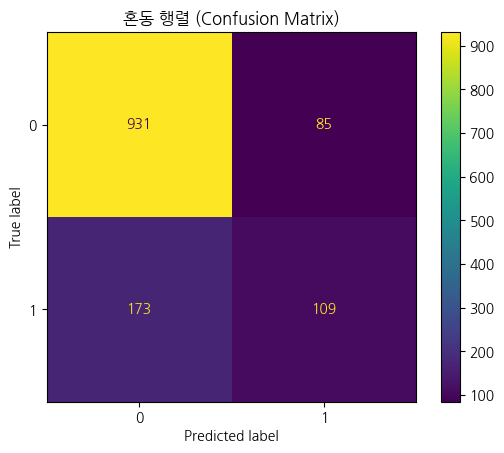

In [184]:
# LabelEncoder 객체 생성
le = LabelEncoder()
# '폐기 발생' -> 0, '폐기 없음' -> 1 으로 변환
y_encoded = le.fit_transform(df['Waste_Or_Not'])


# --- 2단계: XGBClassifier 모델 생성 및 학습 ---
X_class = X # 이전에 선택한 최종 변수 사용
final_features = ['Shelf_Life', 'Product_Name_Milk', 'Location_Karnataka', 'Location_Tamil Nadu', 'Product_Name_Paneer', 'Location_Jharkhand', 'Product_Name_Ice Cream', 'Location_Gujarat', 'Location_Kerala', 'Location_Delhi', 'Location_Telangana', 'Brand_Dodla Dairy', 'Brand_Passion Cheese', 'Location_Chandigarh', 'Brand_Sudha', 'Brand_Dynamix Dairies', 'Brand_Mother Dairy', 'Price_per_Unit', 'Location_Rajasthan', 'Total_Value', 'Brand_Raj', 'Location_Madhya Pradesh', 'Product_Name_Yogurt', 'Number_of_Cows', 'Product_Name_Lassi', 'Brand_Parag Milk Foods', 'Reorder_Quantity', 'Product_Name_Cheese', 'Total_Land_Area', 'Minimum_Stock_Threshold', 'Brand_Palle2patnam', 'Location_Haryana', 'Efficiency_Group_Product_저효율 농장', 'Location_Uttar Pradesh', 'Product_Name_Curd', 'Brand_Warana', 'Location_Maharashtra', 'Location_West Bengal', 'Brand_Britannia Industries', 'Product_Name_Ghee', 'Product_Name_Buttermilk']
X_final = X_class[final_features]

# 데이터를 분리할 때 숫자(0/1)로 변환된 y_encoded를 사용
X_train, X_test, y_train, y_test = train_test_split(X_class, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

xgb_clf = xgb.XGBClassifier(random_state=42, n_jobs=-1)
xgb_clf.fit(X_train, y_train)


# --- 3단계: 모델 성능 평가 ---
y_pred = xgb_clf.predict(X_test)

print("\n--- 이진 분류 모델 평가 리포트 ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

disp.plot()
plt.title('혼동 행렬 (Confusion Matrix)')
plt.show()

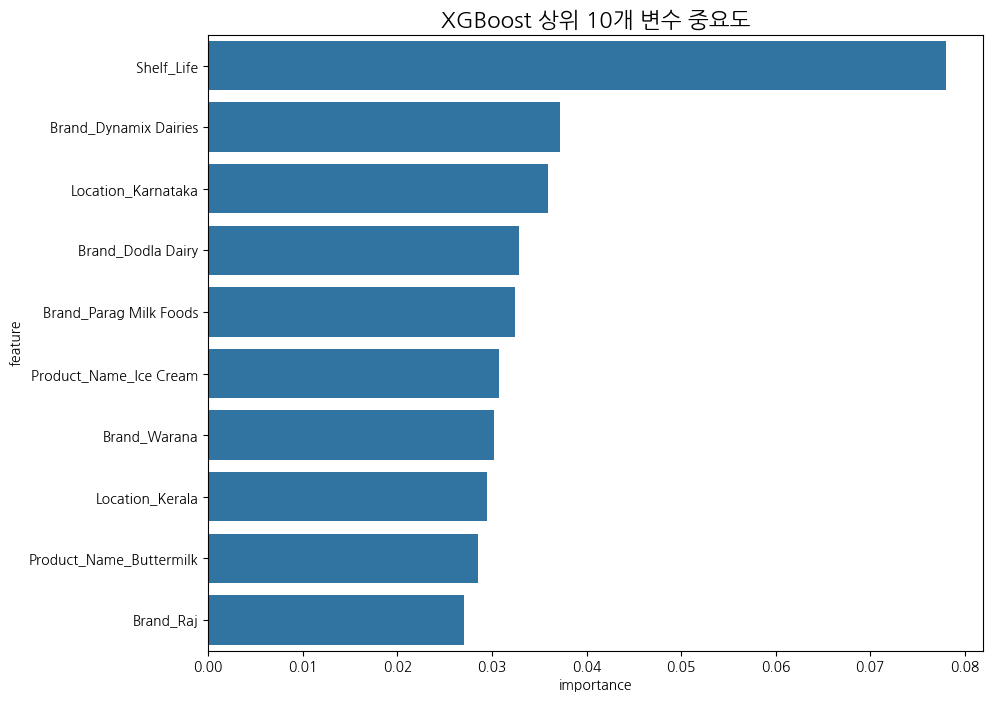

['Shelf_Life', 'Brand_Dynamix Dairies', 'Location_Karnataka', 'Brand_Dodla Dairy', 'Brand_Parag Milk Foods', 'Product_Name_Ice Cream', 'Brand_Warana', 'Location_Kerala', 'Product_Name_Buttermilk', 'Brand_Raj', 'Product_Name_Lassi', 'Product_Name_Ghee', 'Product_Name_Milk', 'Product_Name_Yogurt', 'Location_Gujarat', 'Location_Jharkhand', 'Location_Tamil Nadu', 'Location_Telangana', 'Price_per_Unit', 'Location_Chandigarh', 'Number_of_Cows', 'Location_Maharashtra', 'Reorder_Quantity', 'Total_Value', 'Total_Land_Area', 'Brand_Passion Cheese', 'Location_Rajasthan', 'Product_Name_Paneer', 'Minimum_Stock_Threshold', 'Location_Madhya Pradesh', 'Location_Uttar Pradesh', 'Product_Name_Curd', 'Brand_Palle2patnam', 'Location_Haryana', 'Location_West Bengal', 'Location_Delhi', 'Brand_Mother Dairy', 'Brand_Britannia Industries', 'Efficiency_Group_Product_저효율 농장', 'Brand_Sudha', 'Product_Name_Cheese']


In [185]:
# --- 5. 변수 중요도 (Feature Importance) 확인 ---
feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': xgb_clf.feature_importances_}
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('XGBoost 상위 10개 변수 중요도', fontsize=16)
plt.show()

print([i for i in feature_importances['feature']])

분류 모델 적용 결과 특이도는 낮지만 민감도는 높게 나옴

#### 랜덤포레스트-분류

In [186]:
le = LabelEncoder()
y_class = le.fit_transform(df['Waste_Or_Not'])

features = ['Location', 'Total_Land_Area', 'Number_of_Cows',  'Product_Name', 'Brand', 'Quantity', 'Price_per_Unit', 'Total_Value',
            'Shelf_Life', 'Storage_Condition',  'Customer_Location', 'Sales_Channel', 'Minimum_Stock_Threshold', 'Reorder_Quantity', 'Product_Profile',
            'Prod_Year', 'Prod_Month',  'Prod_per_Cow', 'Prod_per_Acre', 'Efficiency_Group_Product']
X_raw = df[features]
X = pd.get_dummies(X_raw, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [187]:
from sklearn.ensemble import RandomForestClassifier

# 첫 번째 모델 학습
full_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
full_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

--- 전체 변수 중요도 (상위 15개) ---
                           feature  importance
5                       Shelf_Life    0.127742
0                  Total_Land_Area    0.055770
6          Minimum_Stock_Threshold    0.052360
7                 Reorder_Quantity    0.051131
4                      Total_Value    0.050737
10                    Prod_per_Cow    0.050515
2                         Quantity    0.050178
11                   Prod_per_Acre    0.049757
1                   Number_of_Cows    0.049455
3                   Price_per_Unit    0.048441
29               Product_Name_Ghee    0.047401
9                       Prod_Month    0.034969
8                        Prod_Year    0.023181
47  Storage_Condition_Refrigerated    0.017736
27             Product_Name_Cheese    0.012685


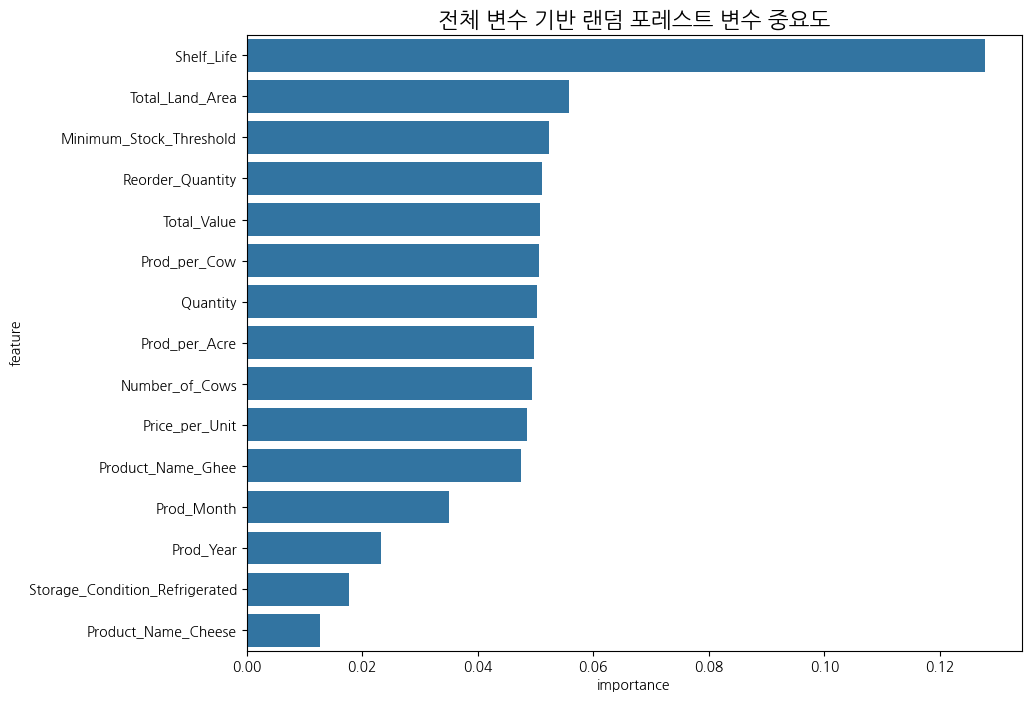

In [188]:
# 변수 중요도를 DataFrame으로 만들어 시각화
importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': full_model.feature_importances_}
).sort_values('importance', ascending=False)

print("--- 전체 변수 중요도 (상위 15개) ---")
print(importances.head(15))

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15))
plt.title('전체 변수 기반 랜덤 포레스트 변수 중요도', fontsize=16)
plt.show()

# 중요도가 높은 상위 N개의 변수만 선택 (예: 상위 10개)
top_features = importances['feature'].head(10).tolist()


--- 최종 모델 평가 리포트 ---
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1016
           1       0.64      0.39      0.49       282

    accuracy                           0.82      1298
   macro avg       0.74      0.67      0.69      1298
weighted avg       0.80      0.82      0.80      1298



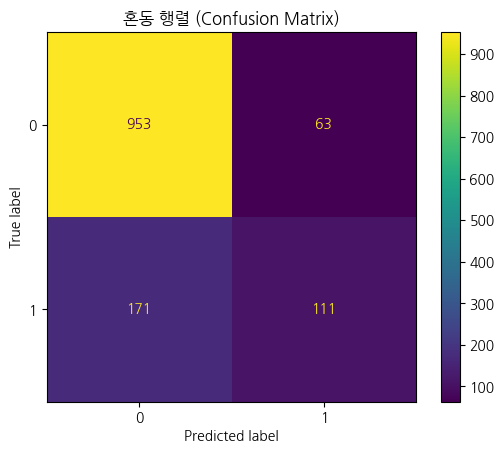

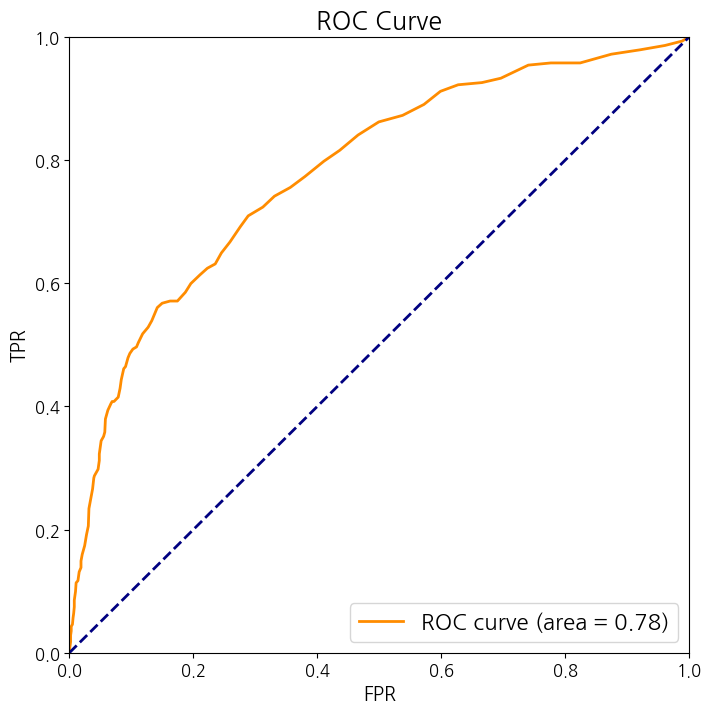

In [189]:
# 선택된 상위 변수들만으로 새로운 X 데이터 생성
X_top = X[top_features]

# 다시 데이터 분리
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y_class, test_size=0.3, random_state=42, stratify=y_class)

# 최종 모델 학습
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_train_top, y_train)

# 최종 모델 성능 평가
y_pred_final = final_model.predict(X_test_top)
print("\n--- 최종 모델 평가 리포트 ---")
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

disp.plot()
plt.title('혼동 행렬 (Confusion Matrix)')
plt.show()

# 1. 각 클래스에 대한 예측 확률 계산
#    predict_proba()는 [클래스 0일 확률, 클래스 1일 확률]을 반환합니다.
y_pred_proba = final_model.predict_proba(X_test_top)[:, 1]

# 2. ROC 커브 계산
#    fpr: False Positive Rate, tpr: True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 3. AUC(Area Under the Curve) 계산
roc_auc = auc(fpr, tpr)

# 4. ROC 커브 시각화
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 무작위 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.show()

--- SMOTE 적용 전 학습 데이터 분포 ---
Counter({np.int64(0): 2371, np.int64(1): 656})

--- SMOTE 적용 후 학습 데이터 분포 ---
Counter({np.int64(1): 2371, np.int64(0): 2371})

--- 최종 모델 평가 리포트 (SMOTE 적용 후) ---
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1016
           1       0.46      0.56      0.51       282

    accuracy                           0.76      1298
   macro avg       0.67      0.69      0.68      1298
weighted avg       0.78      0.76      0.77      1298



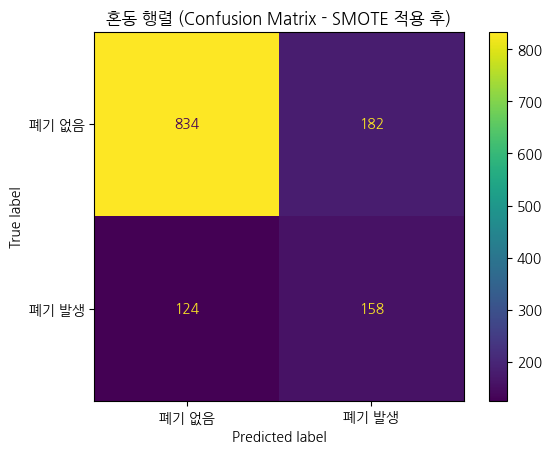

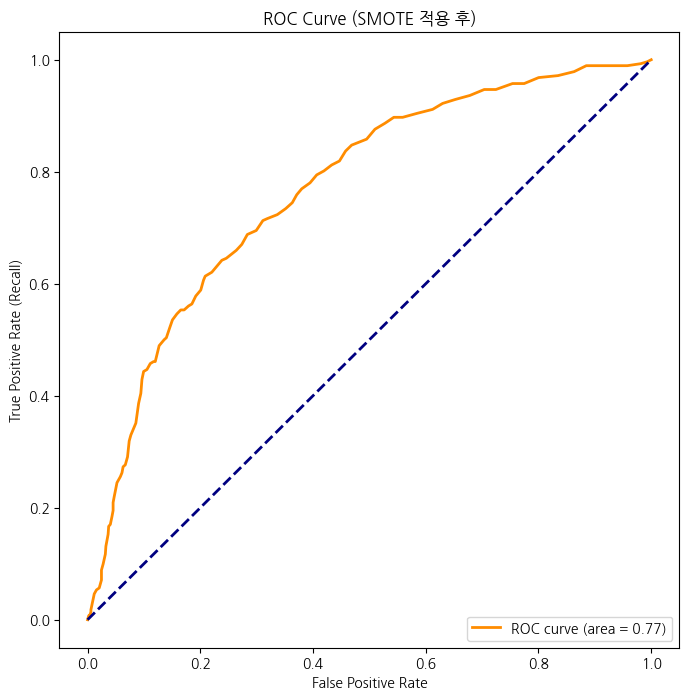

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- 1. 데이터 준비 ---
# y_class: '폐기 발생'(1) / '폐기 없음'(0)으로 변환된 타겟 변수
# X_top: 이전 단계에서 선택된 상위 변수들로 구성된 데이터프레임

# --- 2. 데이터 분리 ---
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y_class, test_size=0.3, random_state=42, stratify=y_class)

# --- 3. SMOTE 오버샘플링 적용 (학습 데이터에만!) ---
print("--- SMOTE 적용 전 학습 데이터 분포 ---")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train_top, y_train)

print("\n--- SMOTE 적용 후 학습 데이터 분포 ---")
print(Counter(y_train_over))


# --- 4. 오버샘플링된 데이터로 최종 모델 학습 ---
final_model_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# SMOTE 처리된 학습 데이터를 사용합니다.
final_model_smote.fit(X_train_over, y_train_over)


# --- 5. 최종 모델 성능 평가 (원본 테스트 데이터 사용) ---
y_pred_final = final_model_smote.predict(X_test_top)
print("\n--- 최종 모델 평가 리포트 (SMOTE 적용 후) ---")
print(classification_report(y_test, y_pred_final))

# --- 6. 혼동 행렬 시각화 ---
cm = confusion_matrix(y_test, y_pred_final, labels=final_model_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['폐기 없음', '폐기 발생'])
disp.plot()
plt.title('혼동 행렬 (Confusion Matrix - SMOTE 적용 후)')
plt.show()

# --- 7. ROC 커브 및 AUC 시각화 ---
y_pred_proba = final_model_smote.predict_proba(X_test_top)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve (SMOTE 적용 후)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
plt.show()

--- SVM 분류 모델 평가 리포트 (SMOTE 적용 후) ---
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1016
           1       0.42      0.62      0.50       282

    accuracy                           0.73      1298
   macro avg       0.65      0.69      0.66      1298
weighted avg       0.78      0.73      0.75      1298



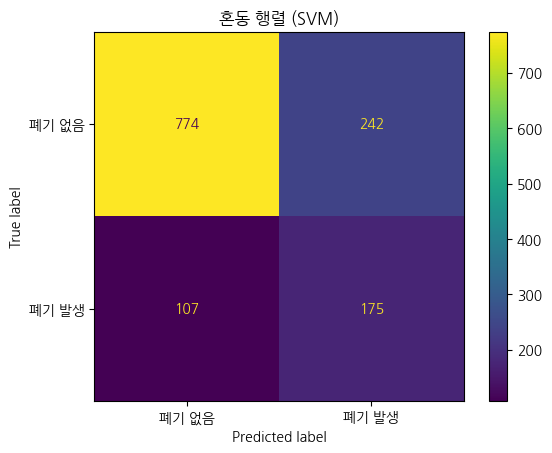

In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# --- 1. 데이터 준비 ---
# y_class: '폐기 발생'(1) / '폐기 없음'(0)으로 변환된 타겟 변수
# X_top: 이전 단계에서 선택된 상위 변수들로 구성된 데이터프레임

# --- 2. 데이터 분리 ---
X_train, X_test, y_train, y_test = train_test_split(X_top, y_class, test_size=0.3, random_state=42, stratify=y_class)

# --- 3. 데이터 스케일링 ---
# SVM은 변수의 스케일에 민감하므로, 표준화가 매우 중요합니다.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. SMOTE 오버샘플링 적용 (학습 데이터에만!) ---
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train_scaled, y_train)


# --- 5. SVM 분류 모델 생성 및 학습 ---
# C: 규제 강도, kernel: 커널 함수, probability=True: 확률 예측 활성화
svm_clf = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
# 오버샘플링되고 스케일링된 학습 데이터로 학습
svm_clf.fit(X_train_over, y_train_over)


# --- 6. 예측 및 성능 평가 ---
# 스케일링된 테스트 데이터로 예측
y_pred = svm_clf.predict(X_test_scaled)

print("--- SVM 분류 모델 평가 리포트 (SMOTE 적용 후) ---")
print(classification_report(y_test, y_pred))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred, labels=svm_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['폐기 없음', '폐기 발생'])
disp.plot()
plt.title('혼동 행렬 (SVM)')
plt.show()

## 비지도학습

### k-means

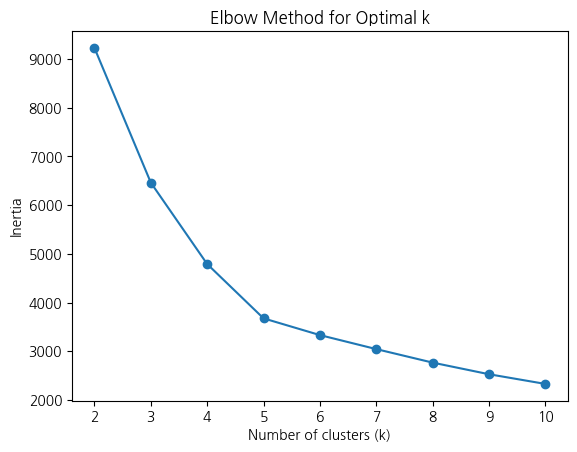

--- 군집별 특성 요약 ---
         Waste_Rate    Quantity  Shelf_Life
cluster                                    
1          0.719970  752.976889   18.276642
0          0.701801  250.087771   18.567941
4          0.157060  764.788283   22.110651
3          0.144919  256.656272   21.006958
2          0.118113  483.322349  101.856549

--- 군집별 데이터 수 ---
cluster
3    1006
4     967
0     942
1     929
2     481
Name: count, dtype: int64


In [192]:

# --- 1. 데이터 준비 및 스케일링 ---
# 1-1. 군집 분석에 사용할 주요 변수 선택
features_for_clustering = ['Waste_Rate', 'Quantity', 'Shelf_Life']

features = ['Location_Mapped', 'Total_Land_Area', 'Number_of_Cows',  'Product_ID', 'Brand_Mapped', 'Quantity', 'Price_per_Unit', 'Total_Value',
            'Shelf_Life', 'Storage_Condition_Mapped',  'Customer_Location_Mapped', 'Sales_Channel_Mapped', 'Minimum_Stock_Threshold', 'Reorder_Quantity',
            'Prod_Year', 'Prod_Month',  'Prod_per_Cow', 'Prod_per_Acre', 'Efficiency_Group_Product_Mapped', 'Waste_Rate']

df_cluster = df[features_for_clustering].dropna()

# 1-2. 데이터 스케일링 (표준화)
# K-Means는 변수의 스케일에 영향을 받으므로 표준화가 필수입니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


# --- 2. 최적의 군집 수(k) 찾기 (Elbow Method) ---
# Inertia 값을 저장할 리스트
inertia = []
# k를 2부터 10까지 테스트
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Elbow Method 시각화
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


# --- 3. K-Means 실행 및 결과 할당 ---
# 위 그래프에서 확인한 최적의 k값으로 K-Means 실행 (예: k=4)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)


# --- 4. 군집 결과 해석 ---
# groupby()를 사용하여 각 군집의 평균적인 특성을 확인
cluster_summary = df_cluster.groupby('cluster').mean().sort_values(by='Waste_Rate', ascending=False)

print("--- 군집별 특성 요약 ---")
print(cluster_summary)

# 군집별 데이터 개수 확인
print("\n--- 군집별 데이터 수 ---")
print(df_cluster['cluster'].value_counts())

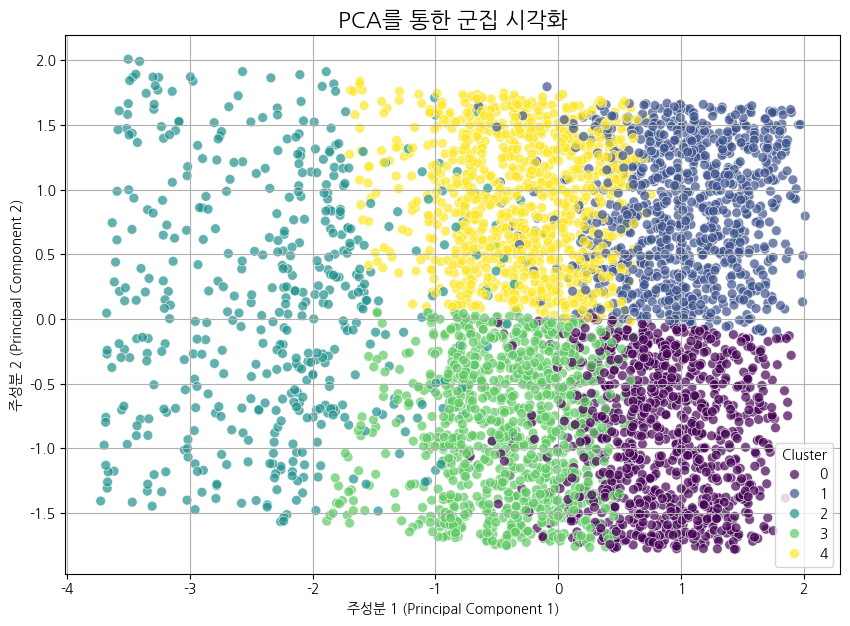

In [193]:
# --- 1. PCA 실행 ---
# X_scaled는 이전에 StandardScaler로 표준화한 데이터입니다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- 2. PCA 결과를 데이터프레임으로 만들고, 군집 라벨 추가 ---
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
# df_cluster는 이전에 K-Means 결과를 담은 데이터프레임입니다.
df_pca['cluster'] = df_cluster['cluster']

# --- 3. 시각화 ---
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('PCA를 통한 군집 시각화', fontsize=16)
plt.xlabel('주성분 1 (Principal Component 1)')
plt.ylabel('주성분 2 (Principal Component 2)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

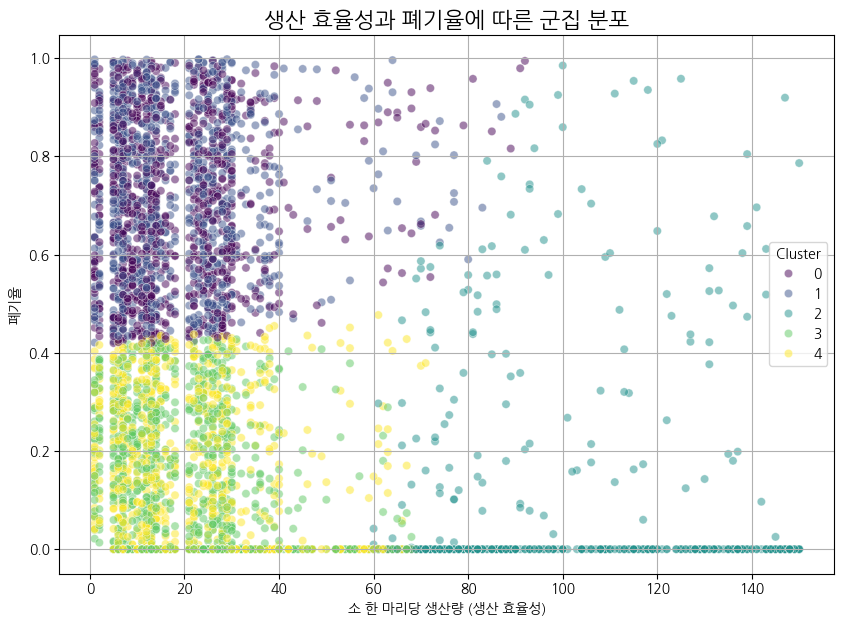

In [194]:
# df_cluster는 K-Means 결과('cluster' 컬럼)와 원본 변수들을 모두 포함하고 있습니다.

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_cluster, x='Shelf_Life', y='Waste_Rate', hue='cluster', palette='viridis', alpha=0.5)
plt.title('생산 효율성과 폐기율에 따른 군집 분포', fontsize=16)
plt.xlabel('소 한 마리당 생산량 (생산 효율성)')
plt.ylabel('폐기율')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

         Waste_Rate    Quantity  Shelf_Life
cluster                                    
1          0.719970  752.976889   18.276642
0          0.701801  250.087771   18.567941
4          0.157060  764.788283   22.110651
3          0.144919  256.656272   21.006958
2          0.118113  483.322349  101.856549


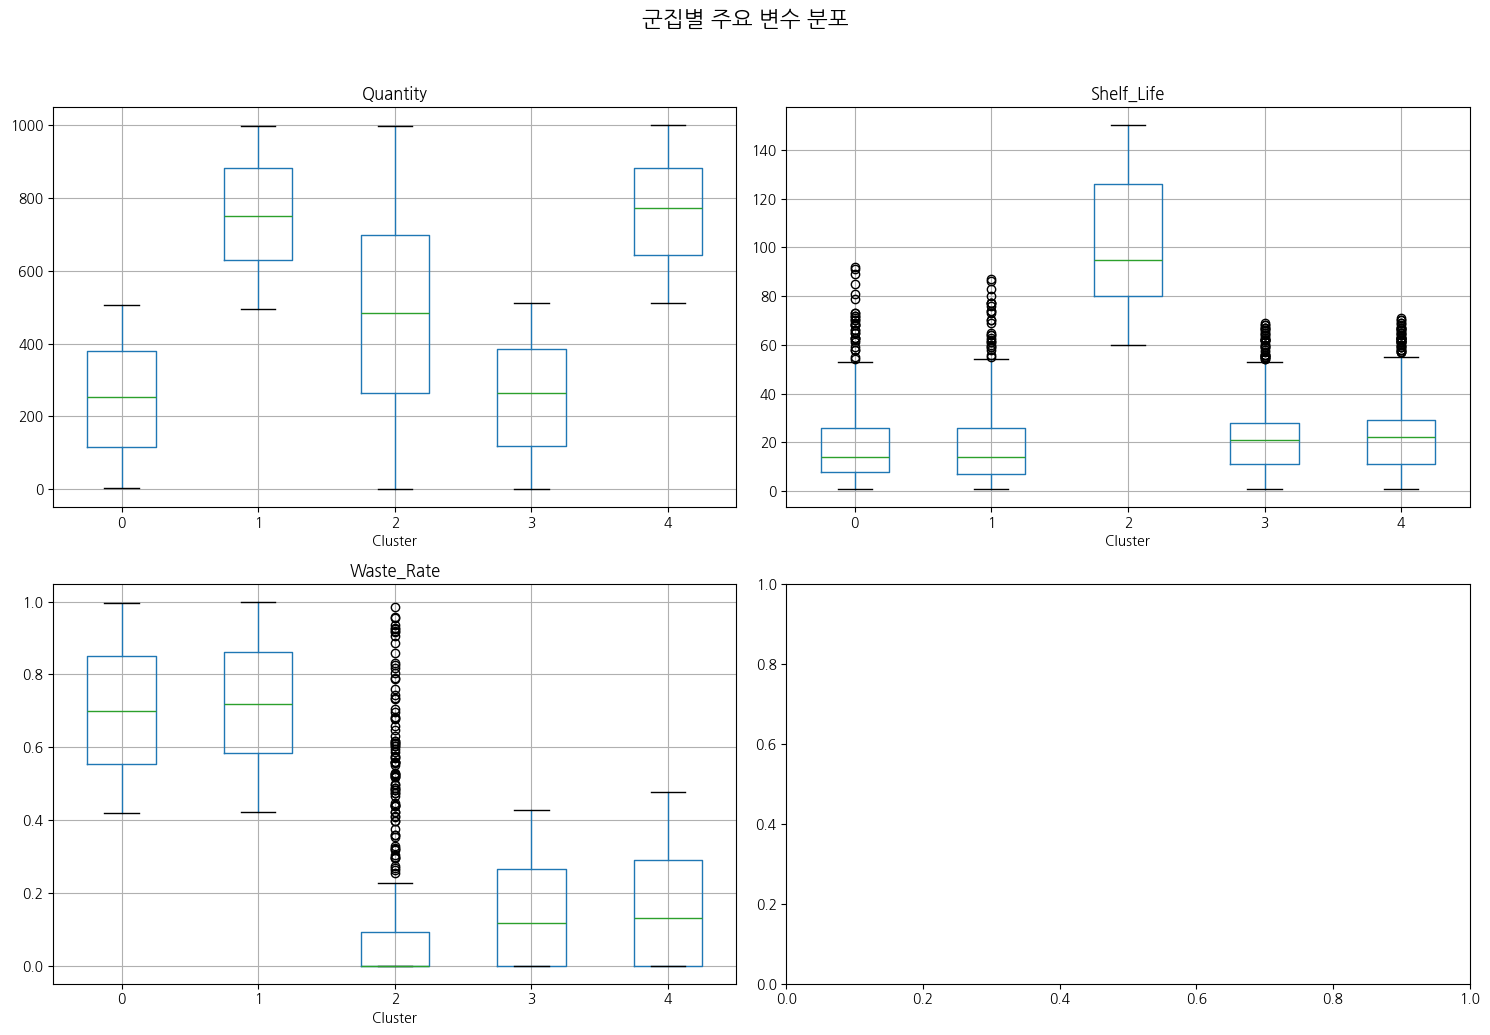

In [195]:
# 이전에 계산했던 군집별 특성 요약표를 다시 확인
print(cluster_summary)

# 1. 시각화할 컬럼 리스트 정의
columns_to_plot = [ 'Quantity', 'Shelf_Life', 'Waste_Rate']

# 2. Subplot 영역 생성
#    layout=(2,3) 대신, 필요한 만큼의 행과 열을 지정합니다 (2행 2열)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# axes.flatten()은 2x2의 축 배열을 1차원으로 만들어 루프를 쉽게 돌게 합니다.
axes = axes.flatten()

# 3. for 루프를 사용하여 각 컬럼별로 boxplot 그리기
for i, col in enumerate(columns_to_plot):
    # 각 축(ax)에 boxplot을 그립니다.
    df_cluster.boxplot(column=col, by='cluster', ax=axes[i])
    axes[i].set_title(col) # 각 그래프의 제목 설정
    axes[i].set_xlabel('Cluster') # x축 레이블 설정

# 4. 전체 레이아웃 조정 및 보여주기
plt.tight_layout()
fig.suptitle('군집별 주요 변수 분포', fontsize=16, y=1.03) # 전체 제목
plt.show()

In [196]:
cluster_summary = cluster_summary.sort_values('Waste_Rate', ascending=True).reset_index()

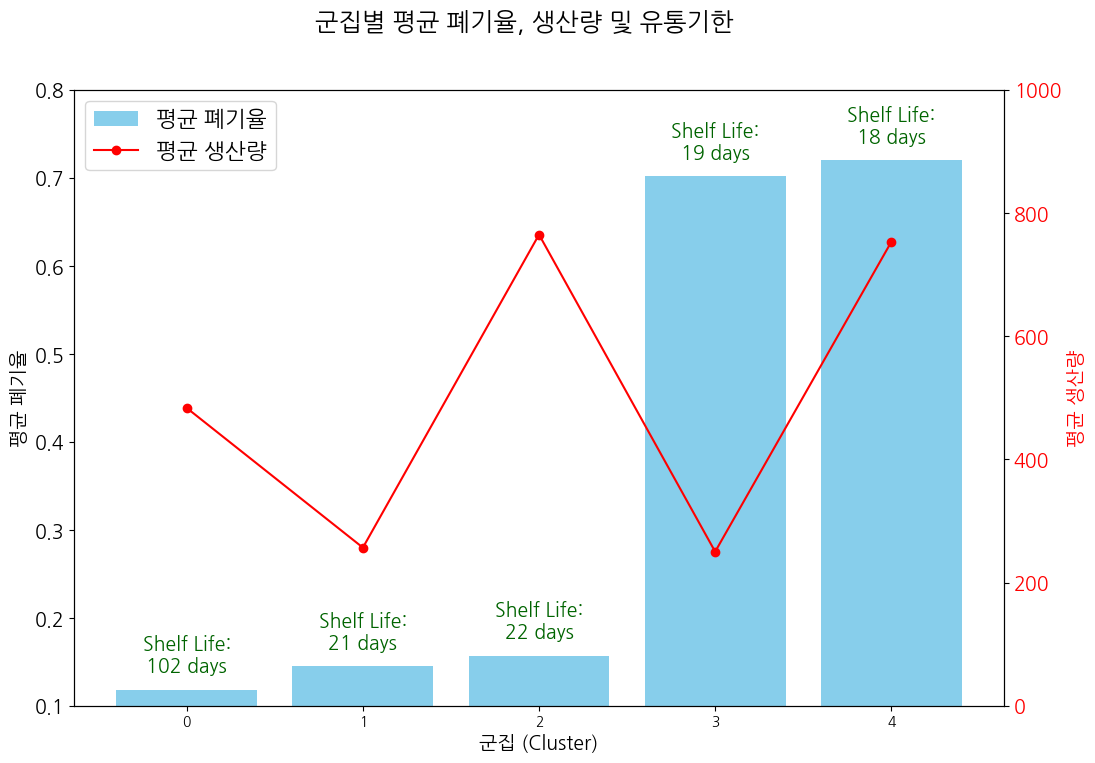

In [197]:
# cluster_summary는 groupby()로 계산된 요약 데이터프레임이라고 가정합니다.
# 예시 데이터 생성
cluster_summary.index.name = 'cluster'


# 1. 그래프 영역과 첫 번째 y축(ax1) 생성
fig, ax1 = plt.subplots(figsize=(12, 8))

# 2. 막대그래프 그리기 (왼쪽 y축 ax1 - 폐기율)
ax1.bar(cluster_summary.index, cluster_summary['Waste_Rate'], color='skyblue', label='평균 폐기율')
ax1.set_xlabel('군집 (Cluster)', fontsize=14)
ax1.set_ylabel('평균 폐기율', color='black', fontsize=14)
ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
ax1.set_ylim(0.1, 0.8)

# 3. 보조 y축(ax2) 생성
ax2 = ax1.twinx()

# 4. 선그래프 그리기 (오른쪽 y축 ax2 - 생산량)
ax2.plot(cluster_summary.index, cluster_summary['Quantity'], color='red', marker='o', label='평균 생산량')
ax2.set_ylabel('평균 생산량', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.set_ylim(0, 1000)

# --- ✨✨✨ 수정된 부분 ✨✨✨ ---
# 5. 각 막대 상단에 평균 유통기한 텍스트로 추가
for index, row in cluster_summary.iterrows():
    ax1.text(
        index, # x 위치 (각 군집의 인덱스)
        row['Waste_Rate'] + 0.02, # y 위치 (막대 높이보다 살짝 위)
        f"Shelf Life:\n{row['Shelf_Life']:.0f} days", # 표시할 텍스트
        ha='center', # 수평 가운데 정렬
        fontsize=14,
        color='darkgreen'
    )
# ------------------------------

# 6. 그래프 꾸미기 및 보여주기
fig.suptitle('군집별 평균 폐기율, 생산량 및 유통기한', fontsize=18)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, fontsize=16, loc='upper left')

plt.show()

In [198]:

# X_scaled: K-Means 학습에 사용했던 스케일링된 데이터
# df_cluster['cluster']: K-Means 모델이 할당한 군집 라벨

# 평균 실루엣 스코어 계산
avg_score = silhouette_score(X_scaled, df_cluster['cluster'])

print(f"전체 평균 실루엣 스코어: {avg_score:.4f}")

# 점수 해석 가이드
if avg_score > 0.5:
    print("▶ 해석: 군집이 비교적 잘 형성되었습니다.")
elif avg_score > 0.25:
    print("▶ 해석: 군집 구조가 어느 정도 존재하지만, 겹치는 부분이 있습니다.")
else:
    print("▶ 해석: 군집 구조가 약하거나 거의 없습니다.")

전체 평균 실루엣 스코어: 0.3464
▶ 해석: 군집 구조가 어느 정도 존재하지만, 겹치는 부분이 있습니다.


#### 군집 분석 버블차트

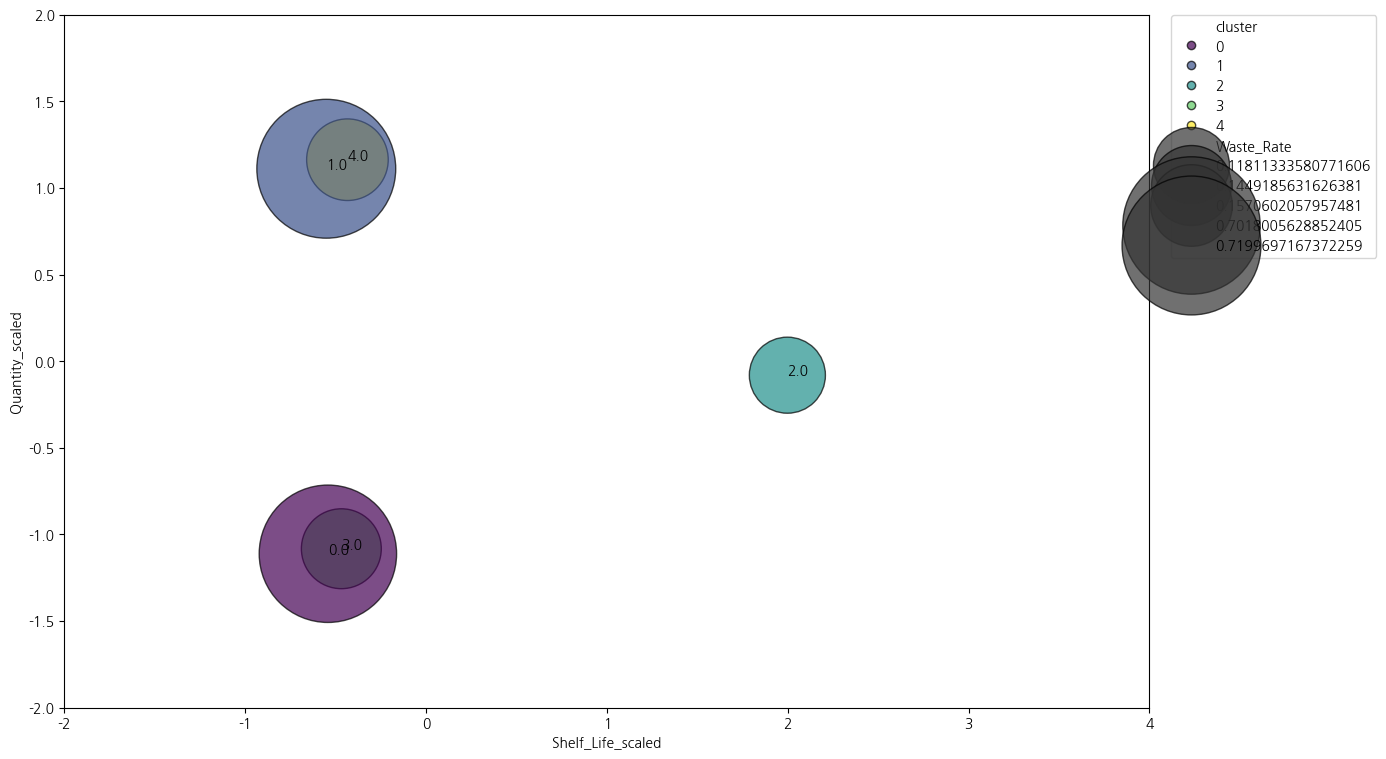

In [204]:
scaler = StandardScaler()

cols_to_scale = ['Quantity', 'Shelf_Life']

cluster_summary_scaled = pd.DataFrame(scaler.fit_transform(cluster_summary[cols_to_scale]),
                         columns=[f"{col}_scaled" for col in cols_to_scale])

cluster_summary_scaled = pd.concat([cluster_summary, cluster_summary_scaled], axis=1)

# 1. 버블 차트 시각화
plt.figure(figsize=(14, 9))
ax = sns.scatterplot(
    data=cluster_summary_scaled,
    x='Shelf_Life_scaled',
    y='Quantity_scaled',
    size='Waste_Rate',
    sizes=(3000, 10000),
    hue='cluster',
    palette='viridis',
    alpha=0.7,
    edgecolor='black',
    linewidth=1
)

texts = []
for i, row in cluster_summary_scaled.iterrows():
    texts.append(ax.text(row['Shelf_Life_scaled'], row['Quantity_scaled'], row['cluster']))

plt.ylim(-2,2)
plt.xlim(-2,4)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()
